In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pdb # Python debugger
from IPython.display import Image, display
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve, train_test_split, GridSearchCV
from keras import models
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l2

sns.set()

%config InlineBackend.figure_format = 'retina' # Increase the figures' resolution in jupyter notebook
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df_train = pd.read_csv('D:/train.csv')
df_test = pd.read_csv('D:/test.csv')
df_data = df_train.append(df_test).reset_index(drop=True)
df_submission = pd.read_csv('D:/gender_submission.csv')

In [3]:
df_data_raw = df_data.copy() # We can use this to restore the mistakes we make in df_data



In [4]:
display(df_train.head(), df_test.head())


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
print('Training null values\n')
print(df_train.isnull().sum()) # to know if there's missing value in the data
print('-'*30)
print('Testing null values\n')
print(df_test.isnull().sum())

Training null values

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
------------------------------
Testing null values

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [6]:
df_submission.head(2)


,PassengerId,Survived
0,892,0
1,893,1


In [7]:
df_data.describe()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [8]:
df_data.describe(include='all')


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,1309.000000,891.000000,1309.000000,1309,1309,1046.000000,1309.000000,1309.000000,1309,1308.000000,295,1307
unique,NaN,NaN,NaN,1307,2,NaN,NaN,NaN,929,NaN,186,3
top,NaN,NaN,NaN,"Connolly, Miss. Kate",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,2,843,NaN,NaN,NaN,11,NaN,6,914
mean,655.000000,0.383838,2.294882,NaN,NaN,29.881138,0.498854,0.385027,NaN,33.295479,NaN,NaN
std,378.020061,0.486592,0.837836,NaN,NaN,14.413493,1.041658,0.865560,NaN,51.758668,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,328.000000,0.000000,2.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,655.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,982.000000,1.000000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.275000,NaN,NaN


,Sex,Survived
0,female,0.742038
1,male,0.188908


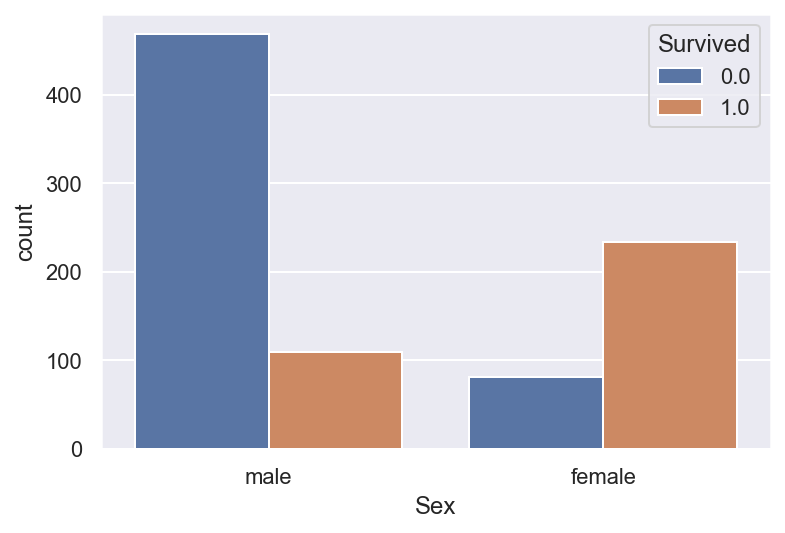

In [9]:
sns.countplot(x=df_data['Sex'], hue=df_data['Survived'])
display(df_data[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean())


,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


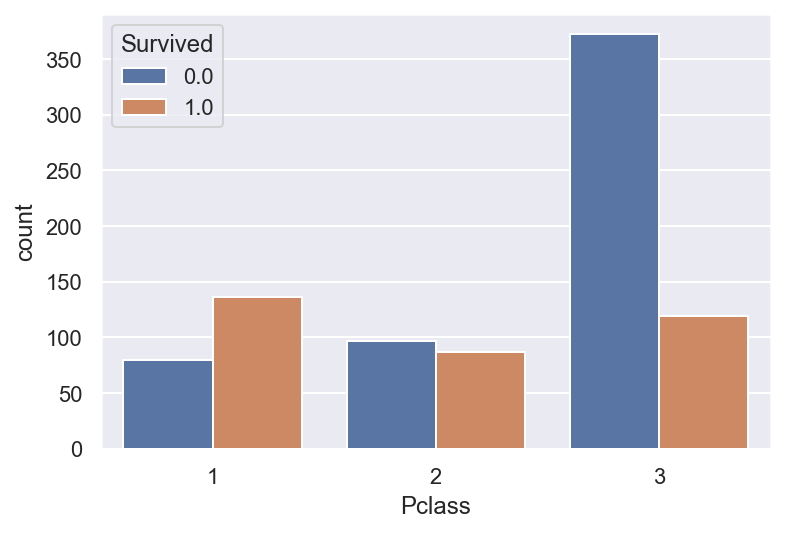

In [10]:
sns.countplot(x=df_data['Pclass'], hue=df_data['Survived'])
display(df_data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean())

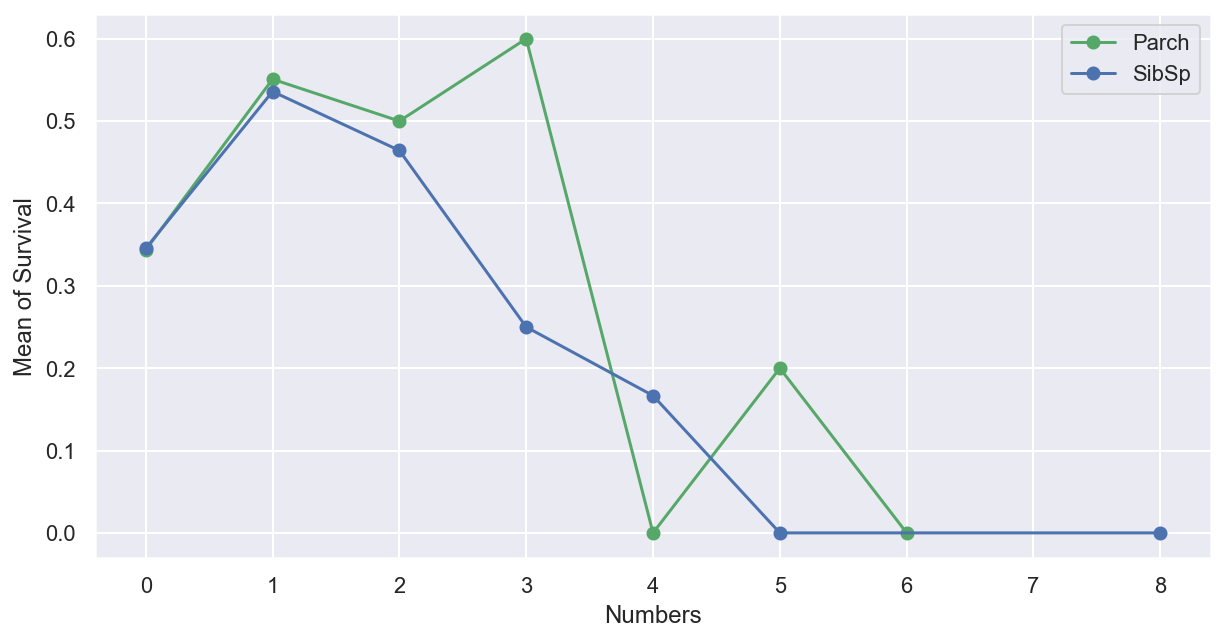

In [11]:
# Split two target data from df_data
df_parch = df_data[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean()
df_sibsp = df_data[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean()

# Plot
fig = plt.figure(figsize=(10, 5))
ax = plt.gca()
ax.plot(df_parch['Parch'], df_parch['Survived'], '-og', label='Parch')
ax.plot(df_sibsp['SibSp'], df_sibsp['Survived'], '-ob', label='SibSp')
ax.set_xlabel('Numbers')
ax.set_ylabel('Mean of Survival')
ax.legend()
plt.show()

In [12]:
# Filling missing values
df_data['Fare'] = df_data['Fare'].fillna(df_data['Fare'].median())

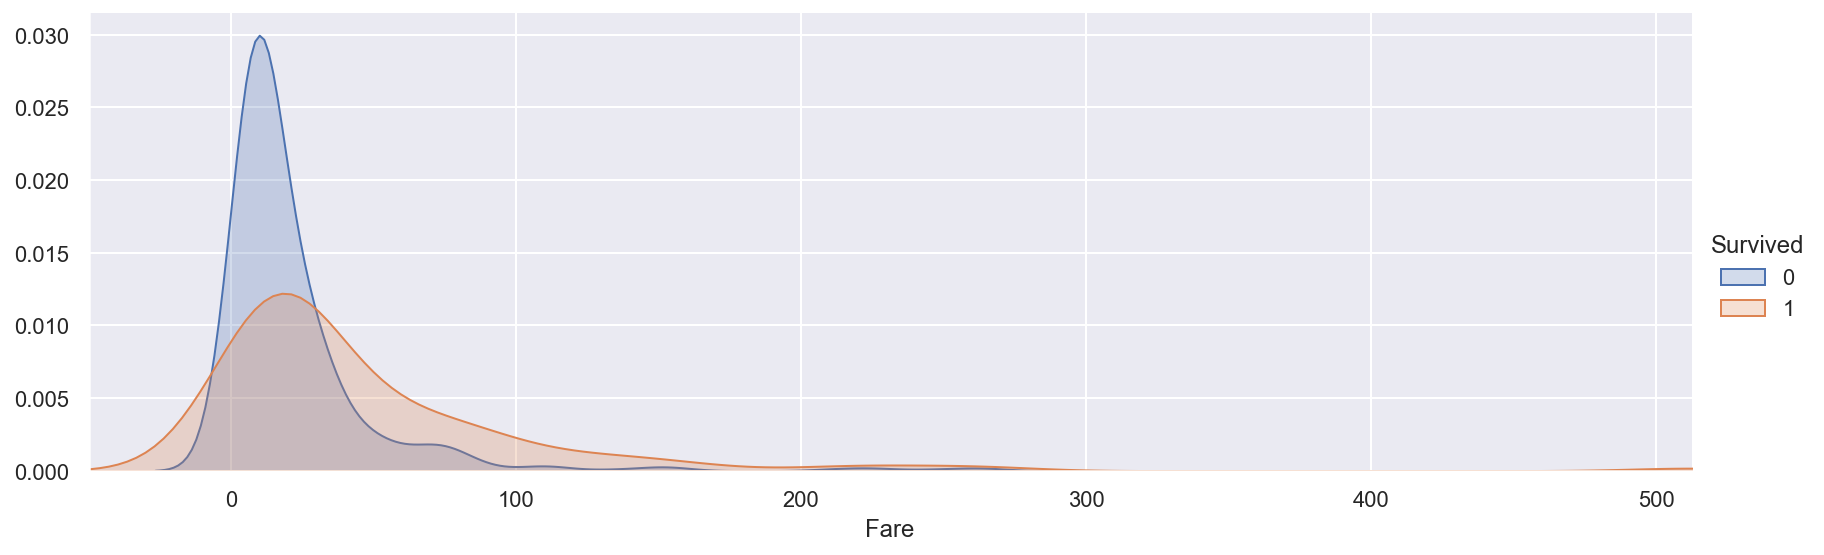

In [13]:
fg = sns.FacetGrid(df_train, hue="Survived",aspect=3, height=4)
fg.map(sns.kdeplot, 'Fare', shade=True)
fg.set(xlim=(-50, df_train['Fare'].max()))
fg.add_legend()
plt.show()

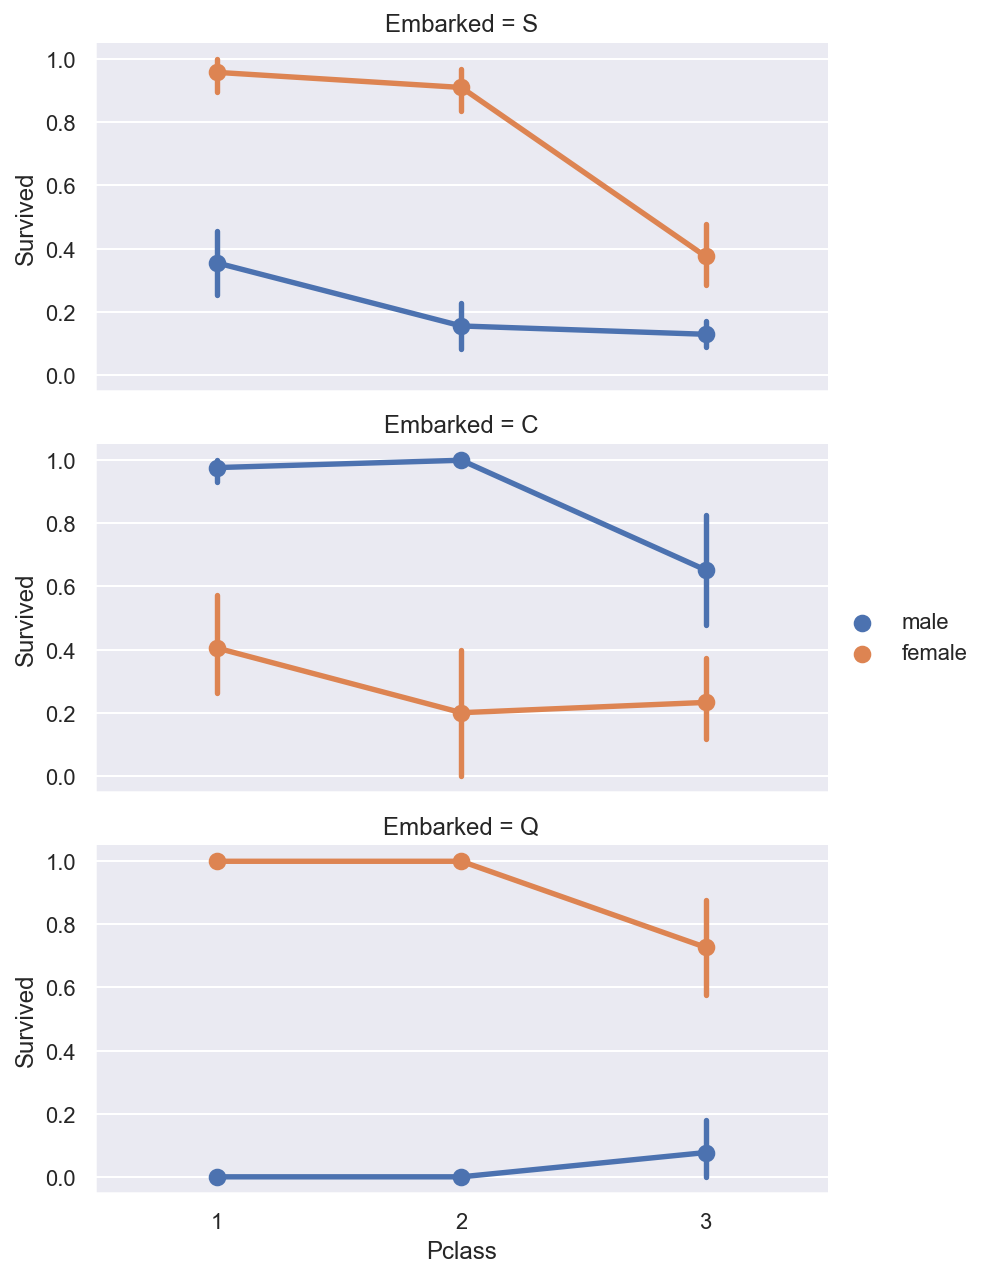

In [14]:
fg = sns.FacetGrid(df_data, row='Embarked', height=3, aspect=2)
fg.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep', hue_order=None, order=[1, 2, 3])
fg.add_legend()
plt.show()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


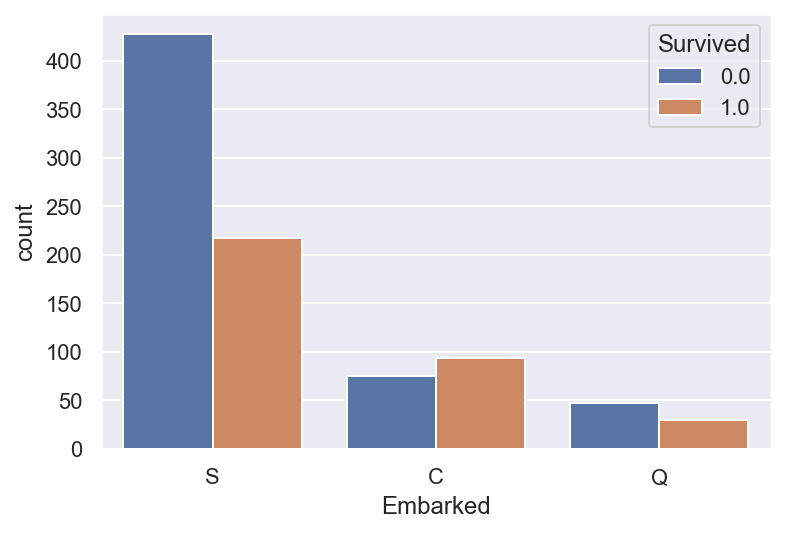

In [15]:
sns.countplot(x=df_data['Embarked'], hue=df_data['Survived'])
display(df_data[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean())

In [16]:
df_data['Sex#'] = df_data['Sex'].map({'male': 0, 'female': 1})



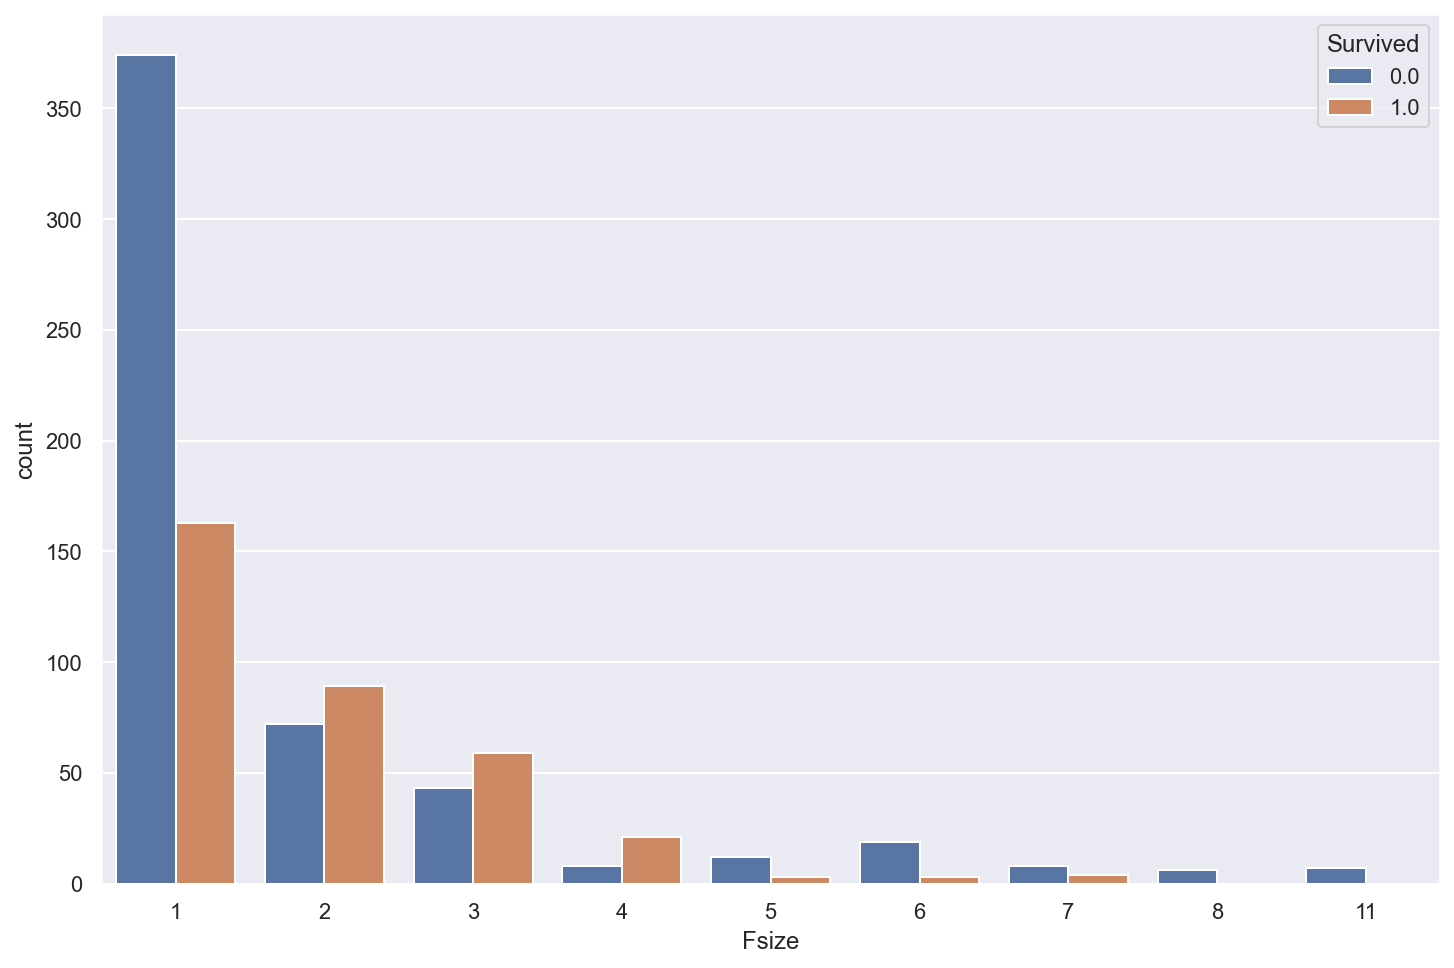

In [17]:
#Create new feature
df_data['Fsize'] = df_data['Parch'] + df_data['SibSp'] + 1 #Fsize stands for faily size = # of parents + # of siblins + self

# Plot
fg = plt.figure(figsize=(12, 8))
sns.countplot(x=df_data['Fsize'], hue=df_data['Survived'])
legend = plt.legend(title='Survived', loc='upper right')
plt.show()

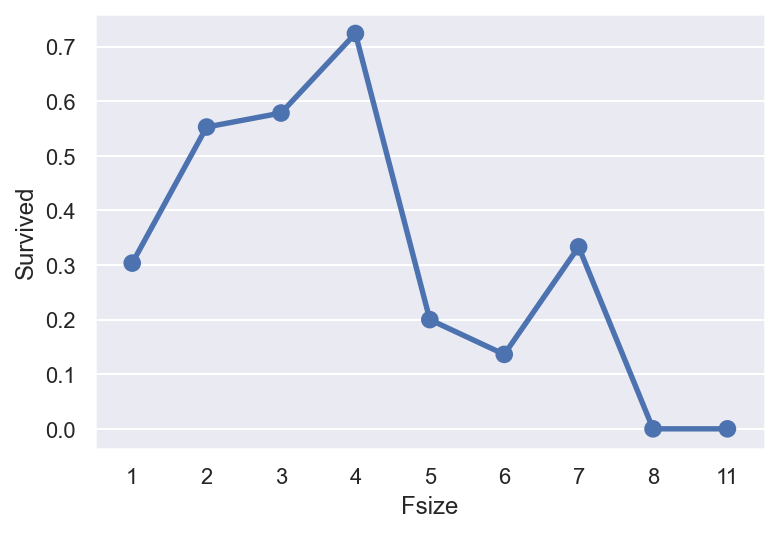

In [18]:
sns.pointplot(x='Fsize', y='Survived', data=df_data[['Fsize', 'Survived']].groupby(['Fsize'], as_index=False).mean())
plt.show()

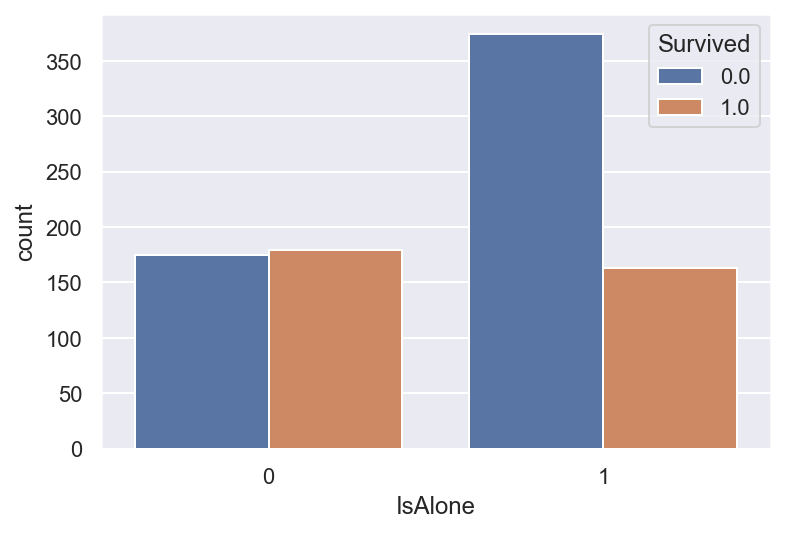

In [19]:
#Create new feature
df_data['IsAlone']  = 0
df_data.loc[df_data.Fsize == 1, 'IsAlone'] = 1

# Plot
sns.countplot(x=df_data['IsAlone'], hue=df_data['Survived'])
plt.show()

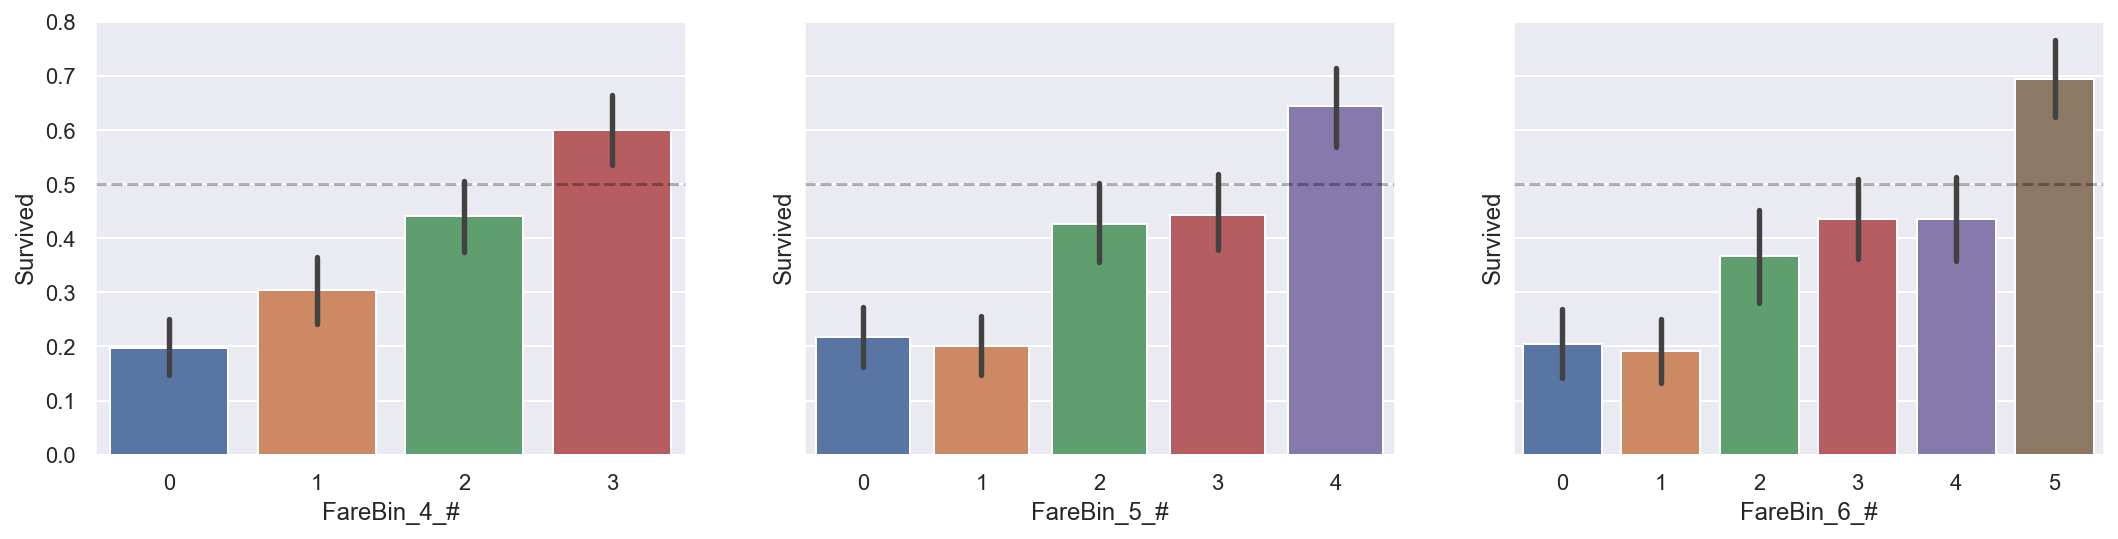

In [20]:
# Making bins
df_data['FareBin_4'] = pd.qcut(df_data['Fare'], 4)
df_data['FareBin_5'] = pd.qcut(df_data['Fare'], 5)
df_data['FareBin_6'] = pd.qcut(df_data['Fare'], 6)

# Mapping the bins
label_encoder = LabelEncoder()
df_data['FareBin_4_#'] = label_encoder.fit_transform(df_data['FareBin_4'])
df_data['FareBin_5_#'] = label_encoder.fit_transform(df_data['FareBin_5'])
df_data['FareBin_6_#'] = label_encoder.fit_transform(df_data['FareBin_6'])

# Plot
fig, [ax1, ax2, ax3] = plt.subplots(1, 3,sharey=True)
fig.set_figwidth(18)
for axi in [ax1, ax2, ax3]:
    axi.axhline(0.5, linestyle='dashed', c='black', alpha = .3)
g1 = sns.barplot(x='FareBin_4_#', y="Survived", data=df_data, ax=ax1)
g2 = sns.barplot(x='FareBin_5_#', y="Survived", data=df_data, ax=ax2)
g3 = sns.barplot(x='FareBin_6_#', y="Survived", data=df_data, ax=ax3)

In [21]:
# splits again beacuse we just engineered new feature
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]

# Training set and labels
x_train = df_train.drop(labels=['Survived','PassengerId'], axis=1)
y_train = df_train['Survived']

# show columns
x_train.columns

Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked', 'Sex#', 'Fsize', 'IsAlone', 'FareBin_4',
       'FareBin_5', 'FareBin_6', 'FareBin_4_#', 'FareBin_5_#', 'FareBin_6_#'],
      dtype='object')

In [22]:
compare_features = ['Sex#','Pclass','FareBin_4_#','FareBin_5_#','FareBin_6_#']
estimator = RandomForestClassifier(n_estimators=250, min_samples_split=20)
selector = RFECV(estimator, cv=10, n_jobs=-1) # cv=10 means using 10-fold cross validation, n_jobs=-1 means using all processors
selector.fit(x_train[compare_features], y_train)

print('The mask of selected features: ', selector.support_) # The mask of selected features.
print('Feature rankings: ', selector.ranking_) # The feature ranking, such that ranking[i] corresponds to the ranking position of the i-th feature. 
print('CV scores: ', selector.grid_scores_*100) # The cross-validation scores such that grid_scores[i] corresponds to the CV score of the i-th subset of features.

The mask of selected features:  [ True  True  True  True  True]
Feature rankings:  [1 1 1 1 1]
CV scores:  [78.67290886 77.44444444 79.46691635 79.13108614 80.47940075]


In [23]:
score_b4,score_b5, score_b6 = [], [], []
seeds = 10

for i in range(seeds):
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=i)
    estimator = RandomForestClassifier(random_state=i, n_estimators=250, min_samples_split=20)
    selector = RFECV(estimator=estimator, cv=cv, n_jobs=-1)
    selector.fit(x_train[compare_features], y_train)
    
    score_b4.append(selector.grid_scores_[2])
    score_b5.append(selector.grid_scores_[3])
    score_b6.append(selector.grid_scores_[4])


# class sklearn.model_selection.StratifiedKFold(n_splits=5, *, shuffle=False, random_state=None)

# Parameters:

# n_splitsint: default=5
# Number of folds, like the k-value in K-fold. Must be at least 2.

# shufflebool: default=False
# Whether to shuffle each class’s samples before splitting into batches. Note that the samples within each split will not be shuffled.

# random_state: RandomState instance or None, default=None
# When shuffle is True, random_state affects the ordering of the indices, which controls the randomness of each fold for each class. Otherwise, leave random_state as None.

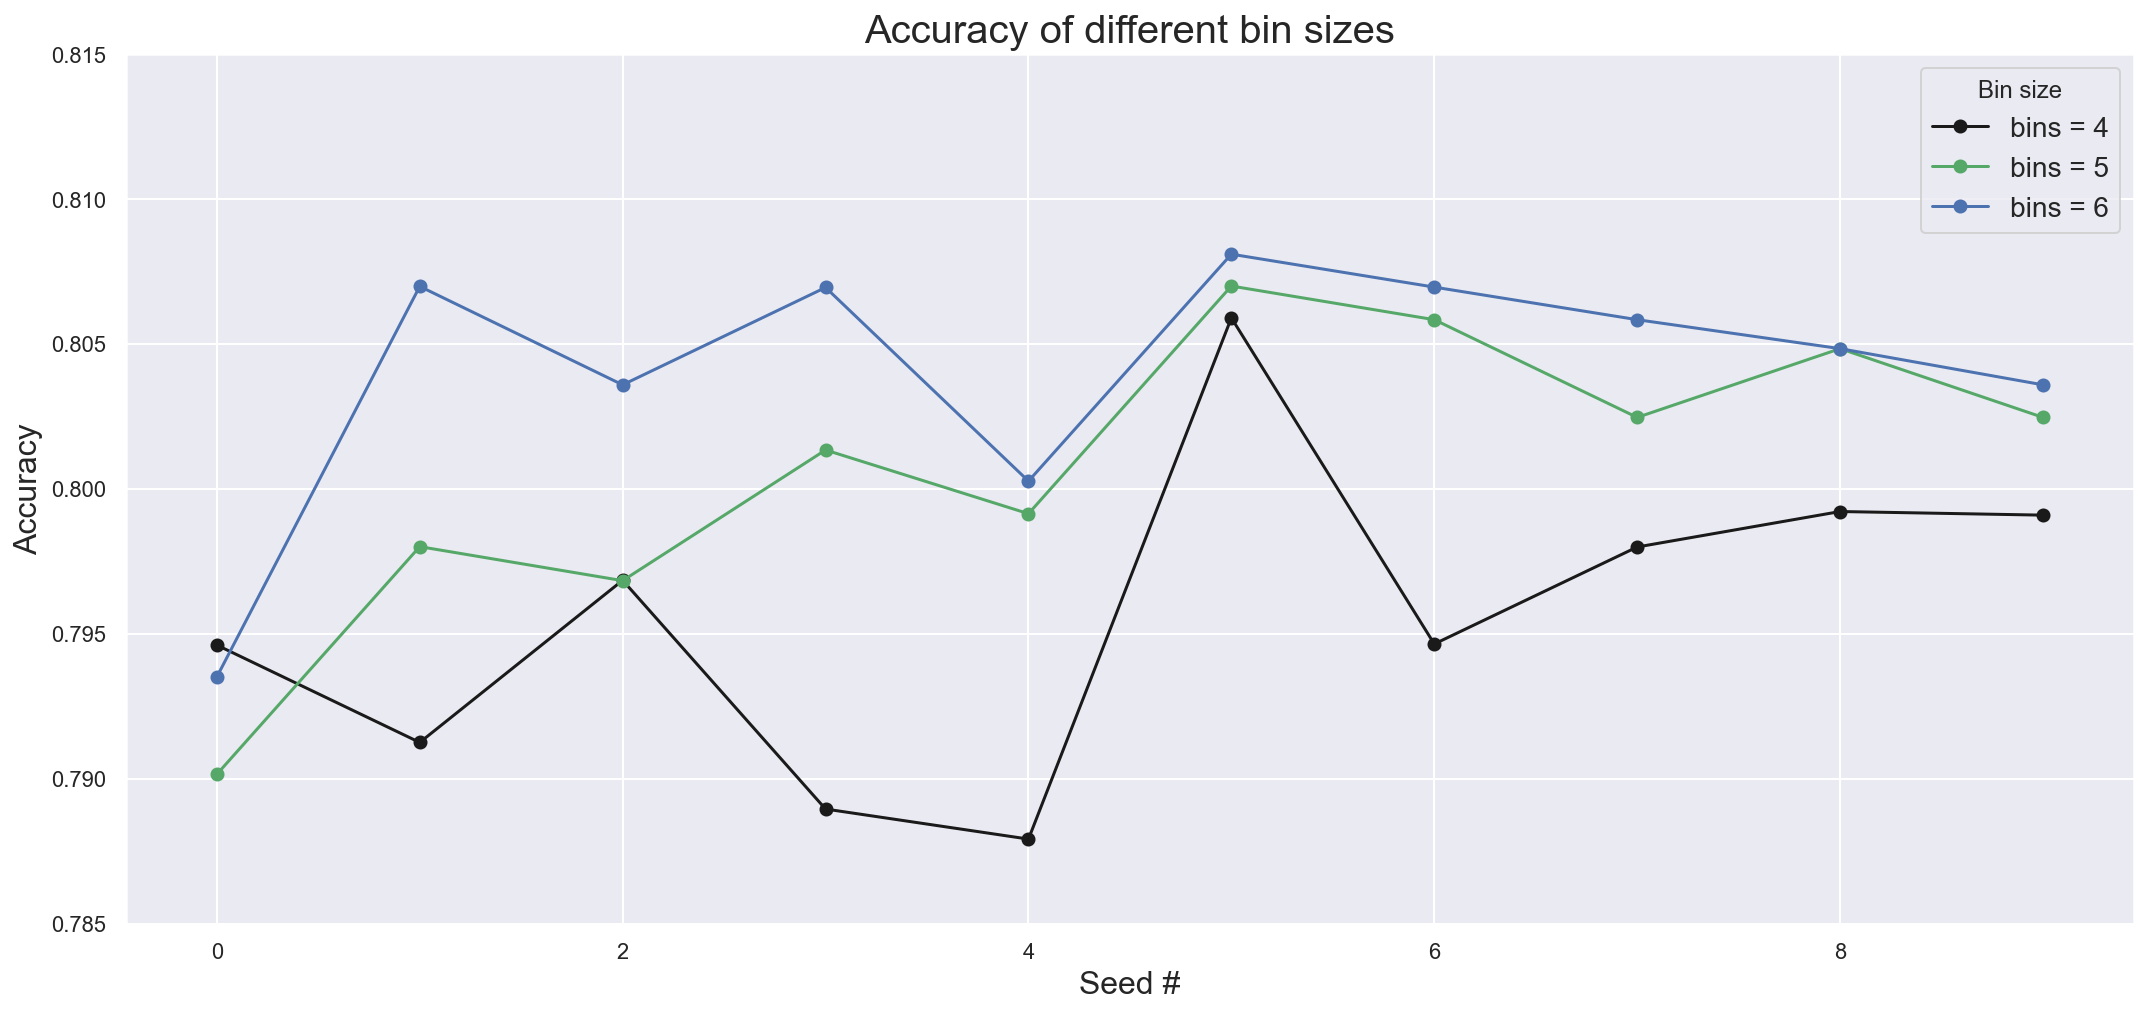

In [24]:
# to np.array
score_list = [score_b4, score_b5, score_b6]
for item in score_list:
    item = np.array(item*100)

# plot
fig = plt.figure(figsize= (18,8))
ax = plt.gca()
ax.plot(range(seeds), score_b4,'-ok',label='bins = 4')
ax.plot(range(seeds), score_b5,'-og',label='bins = 5')
ax.plot(range(seeds), score_b6,'-ob',label='bins = 6')
ax.set_xlabel('Seed #', fontsize=16)
ax.set_ylabel('Accuracy', fontsize=16)
ax.set_ylim(0.785, 0.815)
ax.set_title('Accuracy of different bin sizes', fontsize=20)
plt.legend(fontsize=14, loc='upper right', title='Bin size')
plt.show()

In [25]:
b4, b5, b6 = ['Sex#', 'Pclass','FareBin_4_#'], ['Sex#','Pclass','FareBin_5_#'], ['Sex#','Pclass','FareBin_6_#']

# Train models and predict
b4_Model = RandomForestClassifier(
    random_state=2, 
    n_estimators=250, 
    min_samples_split=20, 
    oob_score=True)
b4_Model.fit(x_train[b4], y_train)

b5_Model = RandomForestClassifier(
    random_state=2, 
    n_estimators=250, 
    min_samples_split=20, 
    oob_score=True)
b5_Model.fit(x_train[b5], y_train)

b6_Model = RandomForestClassifier(
    random_state=2, 
    n_estimators=250, 
    min_samples_split=20, 
    oob_score=True)
b6_Model.fit(x_train[b6], y_train)

# Show oob scores
print('Bin size = 4, oob score :{}'.format(b4_Model.oob_score_))
print('Bin size = 5, oob score :{}'.format(b5_Model.oob_score_))
print('Bin size = 6, oob score :{}'.format(b6_Model.oob_score_))

Bin size = 4, oob score :0.8058361391694725
Bin size = 5, oob score :0.8103254769921436
Bin size = 6, oob score :0.8013468013468014


In [26]:
# Drop features we created in the process exclude FareBin_5_# which is what we need
df_data['FareBin'] = df_data['FareBin_5_#']
df_data = df_data.drop(['FareBin_4', 'FareBin_5', 'FareBin_6', 'FareBin_4_#', 'FareBin_5_#', 'FareBin_6_#'], axis=1)

In [27]:
df_data['Fname'] = df_data['Name'].str.extract('([A-Za-z]+.[A-Za-z]+)\,', expand=True)



In [28]:
duplicates = []

for uniq in df_data['Ticket'].unique():
    temp = df_data.loc[df_data['Ticket'] == uniq, 'Name']
    if temp.count() > 1:
        duplicates.append(df_data.loc[df_data['Ticket'] == uniq, ['Name', 'Ticket', 'Fare', 'FareBin', 'Fsize', 'Survived']])
duplicates = pd.concat(duplicates)
duplicates.head(20)

,Name,Ticket,Fare,FareBin,Fsize,Survived
1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",PC 17599,71.2833,4,2,1.0
1125,"Cumings, Mr. John Bradley",PC 17599,71.2833,4,2,NaN
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,53.1000,4,2,1.0
137,"Futrelle, Mr. Jacques Heath",113803,53.1000,4,2,0.0
6,"McCarthy, Mr. Timothy J",17463,51.8625,4,1,0.0
1037,"Hilliard, Mr. Herbert Henry",17463,51.8625,4,1,NaN
7,"Palsson, Master. Gosta Leonard",349909,21.0750,2,5,0.0
24,"Palsson, Miss. Torborg Danira",349909,21.0750,2,5,0.0
374,"Palsson, Miss. Stina Viola",349909,21.0750,2,5,0.0
567,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",349909,21.0750,2,5,0.0


In [29]:
df_friend = duplicates.loc[(duplicates.Fsize == 1) & (duplicates.Survived.notnull())]
df_family = duplicates.loc[(duplicates.Fsize > 1) & (duplicates.Survived.notnull())]
display(df_friend.head(), df_family.head())

,Name,Ticket,Fare,FareBin,Fsize,Survived
6,"McCarthy, Mr. Timothy J",17463,51.8625,4,1,0.0
20,"Fynney, Mr. Joseph J",239865,26.0000,3,1,0.0
791,"Gaskell, Mr. Alfred",239865,26.0000,3,1,0.0
195,"Lurette, Miss. Elise",PC 17569,146.5208,4,1,1.0
681,"Hassab, Mr. Hammad",PC 17572,76.7292,4,1,1.0


,Name,Ticket,Fare,FareBin,Fsize,Survived
1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",PC 17599,71.2833,4,2,1.0
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,53.1000,4,2,1.0
137,"Futrelle, Mr. Jacques Heath",113803,53.1000,4,2,0.0
7,"Palsson, Master. Gosta Leonard",349909,21.0750,2,5,0.0
24,"Palsson, Miss. Torborg Danira",349909,21.0750,2,5,0.0


In [30]:
print('Passengers taking the same ticket: ', duplicates['Name'].count())
print('Family: ', df_family['Name'].count())
print('Friend: ', df_friend['Name'].count())
print('Other: ', duplicates['Name'].count() - df_family['Name'].count() - df_friend['Name'].count())

Passengers taking the same ticket:  596
Family:  321
Friend:  89
Other:  186


In [31]:
df_data['Connected_Survival'] = 0.5

for ticket_num, df_grp in df_data.groupby('Ticket'):
    if len(df_grp) > 1: # We just want the data with duplicated tickets
            for index, row in df_grp.iterrows():
                smax = df_grp.drop(index).Survived.max()
                smin = df_grp.drop(index).Survived.min()
                pid = row.PassengerId
                if smax == 1.0:
                    df_data.loc[df_data['PassengerId'] == pid, 'Connected_Survival'] = 1
                elif smin == 0.0:
                    df_data.loc[df_data['PassengerId'] == pid, 'Connected_Survival'] = 0

In [32]:
# Take a look at the missing values
df_data[df_data['Embarked'].isnull()][['Embarked', 'Pclass', 'FareBin']]

,Embarked,Pclass,FareBin
61,NaN,1,4
829,NaN,1,4


In [33]:
# Check their relation in groups
df_data.groupby(['Embarked', 'Pclass'])[['FareBin']].median()

FareBin
Embarked Pclass         
C        1             4
         2             2
         3             1
Q        1             4
         2             2
         3             0
S        1             4
         2             2
         3             1

In [34]:
# Take a look at the missing values. Using Fare instead of FareBin
df_data[df_data['Embarked'].isnull()][['Embarked', 'Pclass', 'Fare']]

,Embarked,Pclass,Fare
61,NaN,1,80.0
829,NaN,1,80.0


In [35]:
# Check their relation in groups
df_data.groupby(['Embarked', 'Pclass'])[['Fare']].median()

Fare
Embarked Pclass         
C        1       76.7292
         2       15.3146
         3        7.8958
Q        1       90.0000
         2       12.3500
         3        7.7500
S        1       52.0000
         2       15.3750
         3        8.0500

In [36]:
# Filling missing values with the value that has greatest frequency
df_data['Embarked'] = df_data['Embarked'].fillna('C')

# Mapping
df_data['Embarked#'] = df_data['Embarked'].map({'S': 1, 'C': 2, 'Q': 3})
df_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex#,Fsize,IsAlone,FareBin,Fname,Connected_Survival,Embarked#
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,2,0,0,Braund,0.5,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C,1,2,0,4,Cumings,0.5,2
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1,1,1,Heikkinen,0.5,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,2,0,4,Futrelle,0.0,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,1,1,1,Allen,0.5,1


In [37]:
df_data['Title'] = df_data['Name'].str.extract('([A-Za-z]+)\.', expand=False)
df_data['Title'] = df_data['Title'].replace(['Capt', 'Col', 'Rev', 'Don', 'Countess', 'Jonkheer', 'Dona', 'Sir', 'Dr', 'Major', 'Dr'], 'Rare')
df_data['Title'] = df_data['Title'].replace(['Mlle', 'Mme', 'Ms'], 'Miss')
df_data['Title'] = df_data['Title'].replace(['Lady'], 'Mrs')
df_data['Title'] = df_data['Title'].map({"Mr":0, "Rare" : 1, "Master" : 2,"Miss" : 3, "Mrs" : 4 })

In [38]:
df_data.Age.describe()


count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64

In [39]:
df_data.loc[df_data.Age.notnull(), 'Age'] = df_data.loc[df_data.Age.notnull(), 'Age'].apply(np.ceil).astype('int')

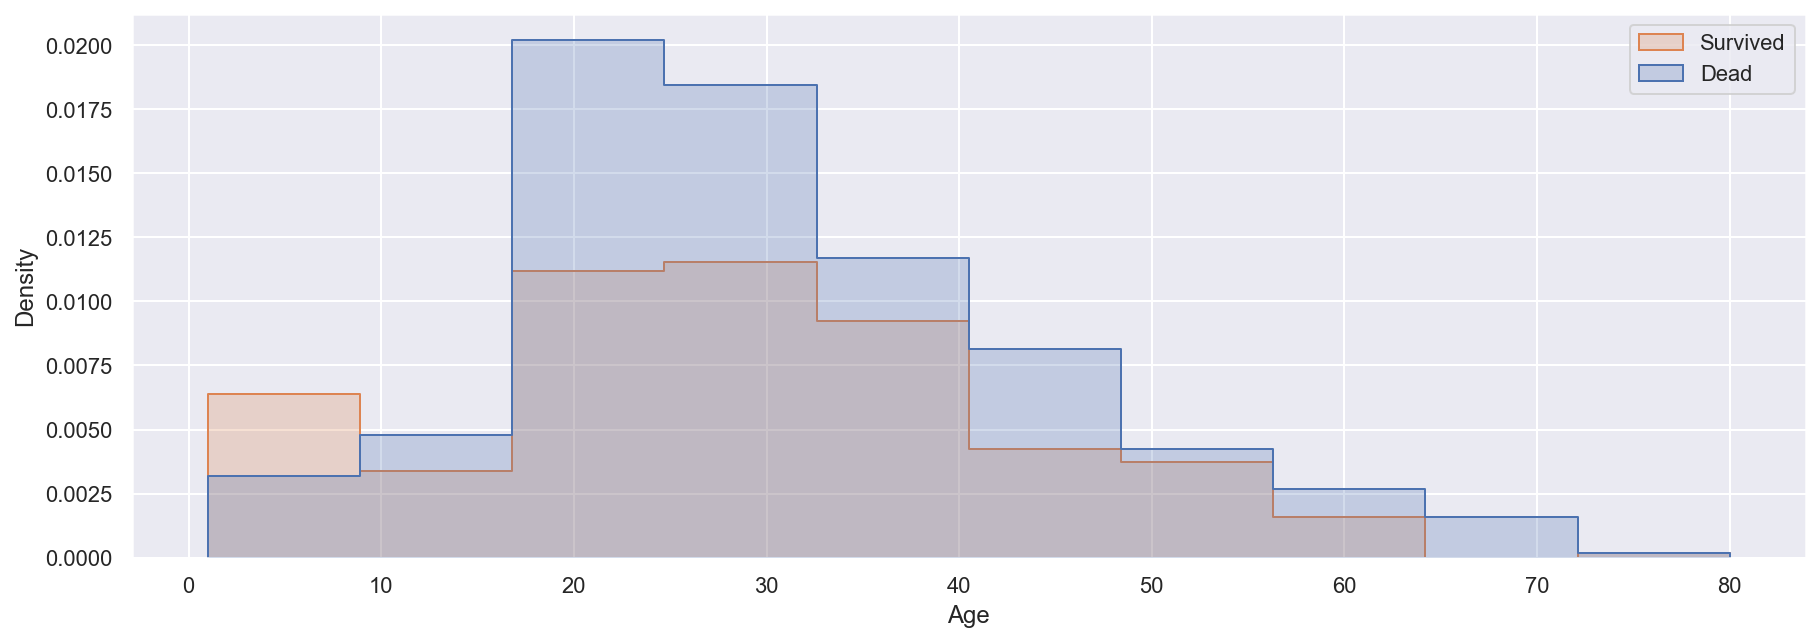

In [40]:
df_age = df_data.loc[(df_data.Age.notnull() & df_data.Survived.notnull())]

fg, ax = plt.subplots(figsize=(15, 5))
ax = sns.histplot(df_age, x='Age', hue='Survived', kde=False, bins=10, palette='deep', label='Survived', element='step', stat='density')
ax.legend(['Survived', 'Dead'])
plt.show()

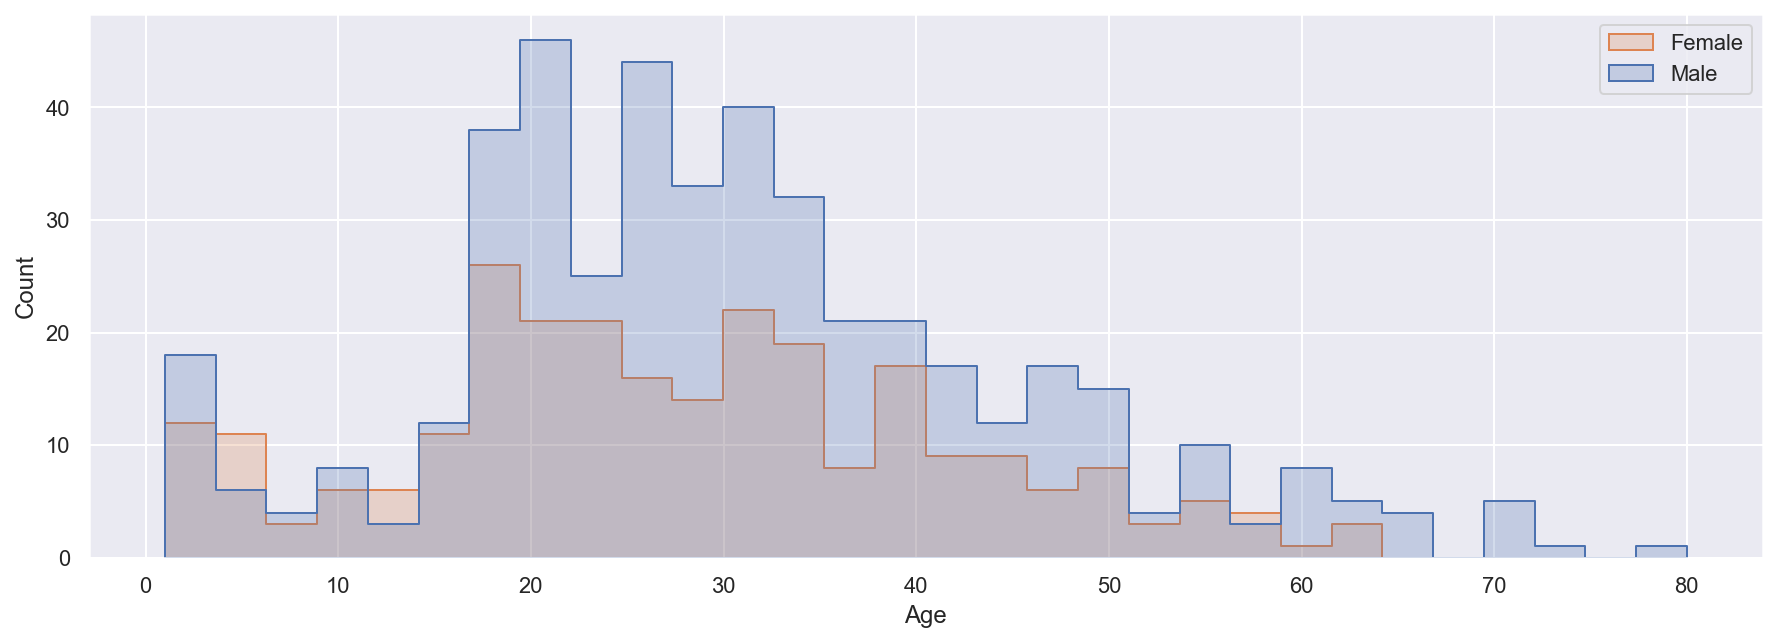

In [41]:
df_sex = df_data.loc[df_data.Age.notnull()]

fg, ax = plt.subplots(figsize=(15, 5))
ax = sns.histplot(df_age, x='Age', hue='Sex', kde=False, bins=30, palette='deep', label='Sex', element='step')
ax.legend(['Female', 'Male'])
plt.show()

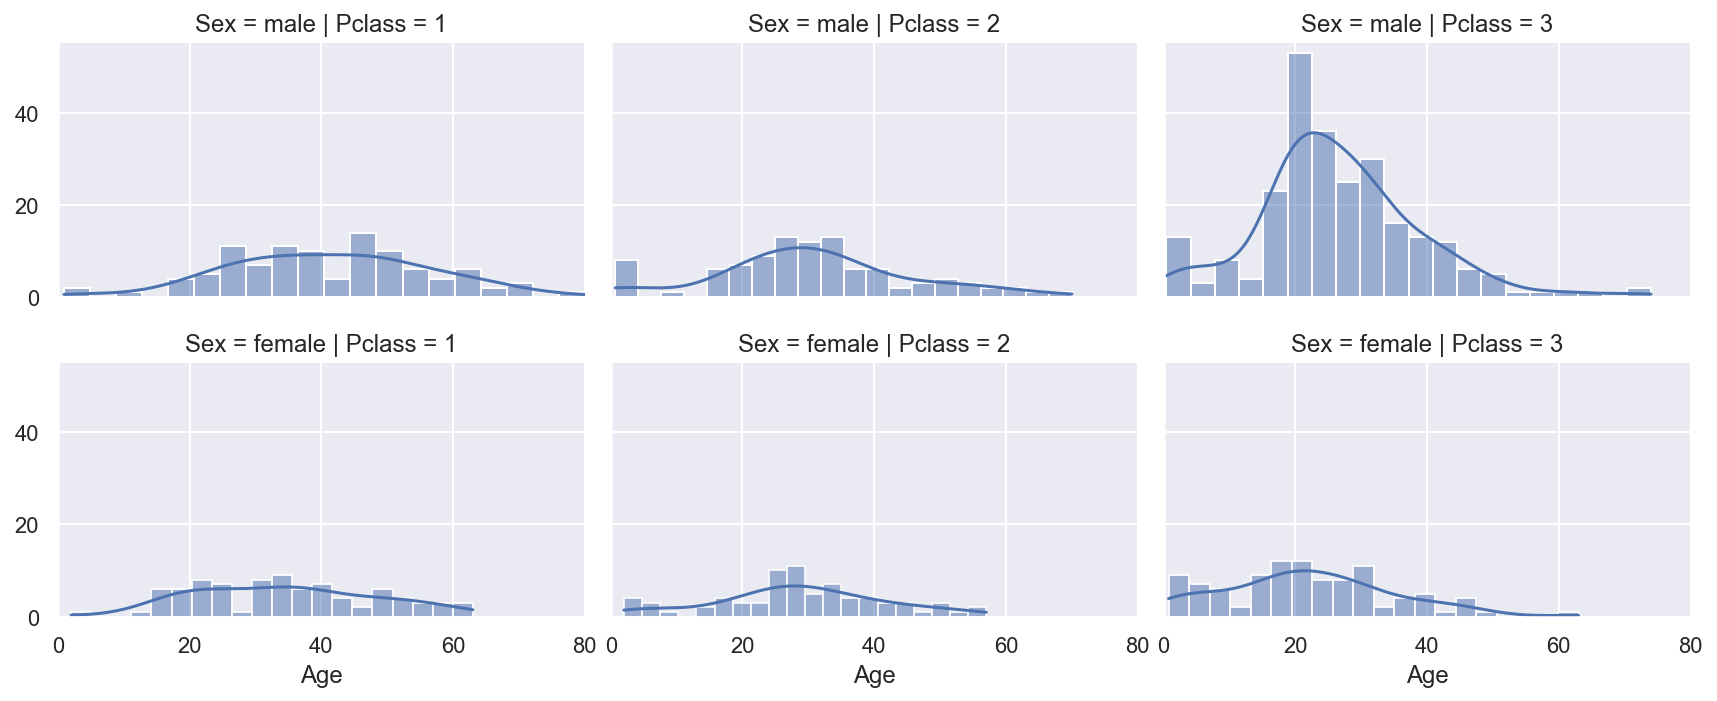

In [42]:
grid = sns.FacetGrid(df_train, row='Sex', col='Pclass', height=2.5, aspect=1.6)
grid.map(sns.histplot, 'Age',kde=True, alpha=.5, bins=20)
grid.set(xlim=(0, 80), ylim=(0, 55))
plt.show()

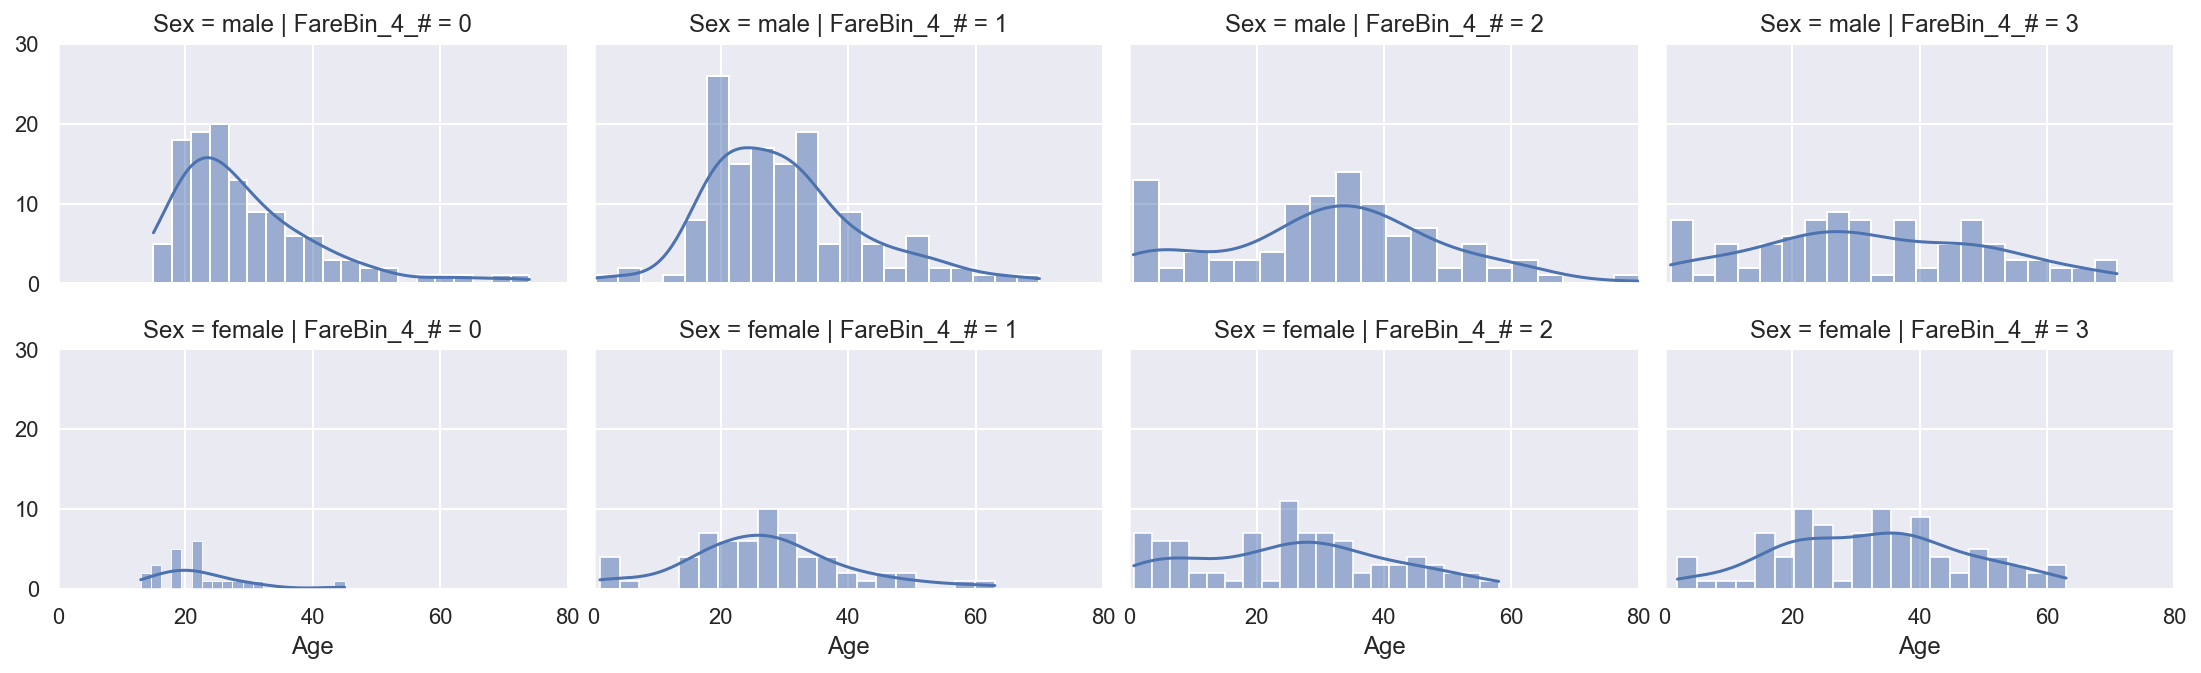

In [43]:
grid = sns.FacetGrid(df_train, row='Sex', col='FareBin_4_#', height=2.4, aspect=1.6)
grid.map(sns.histplot, 'Age',kde=True, alpha=.5, bins=20)
grid.set(xlim=(0, 80), ylim=(0, 30))
plt.show()

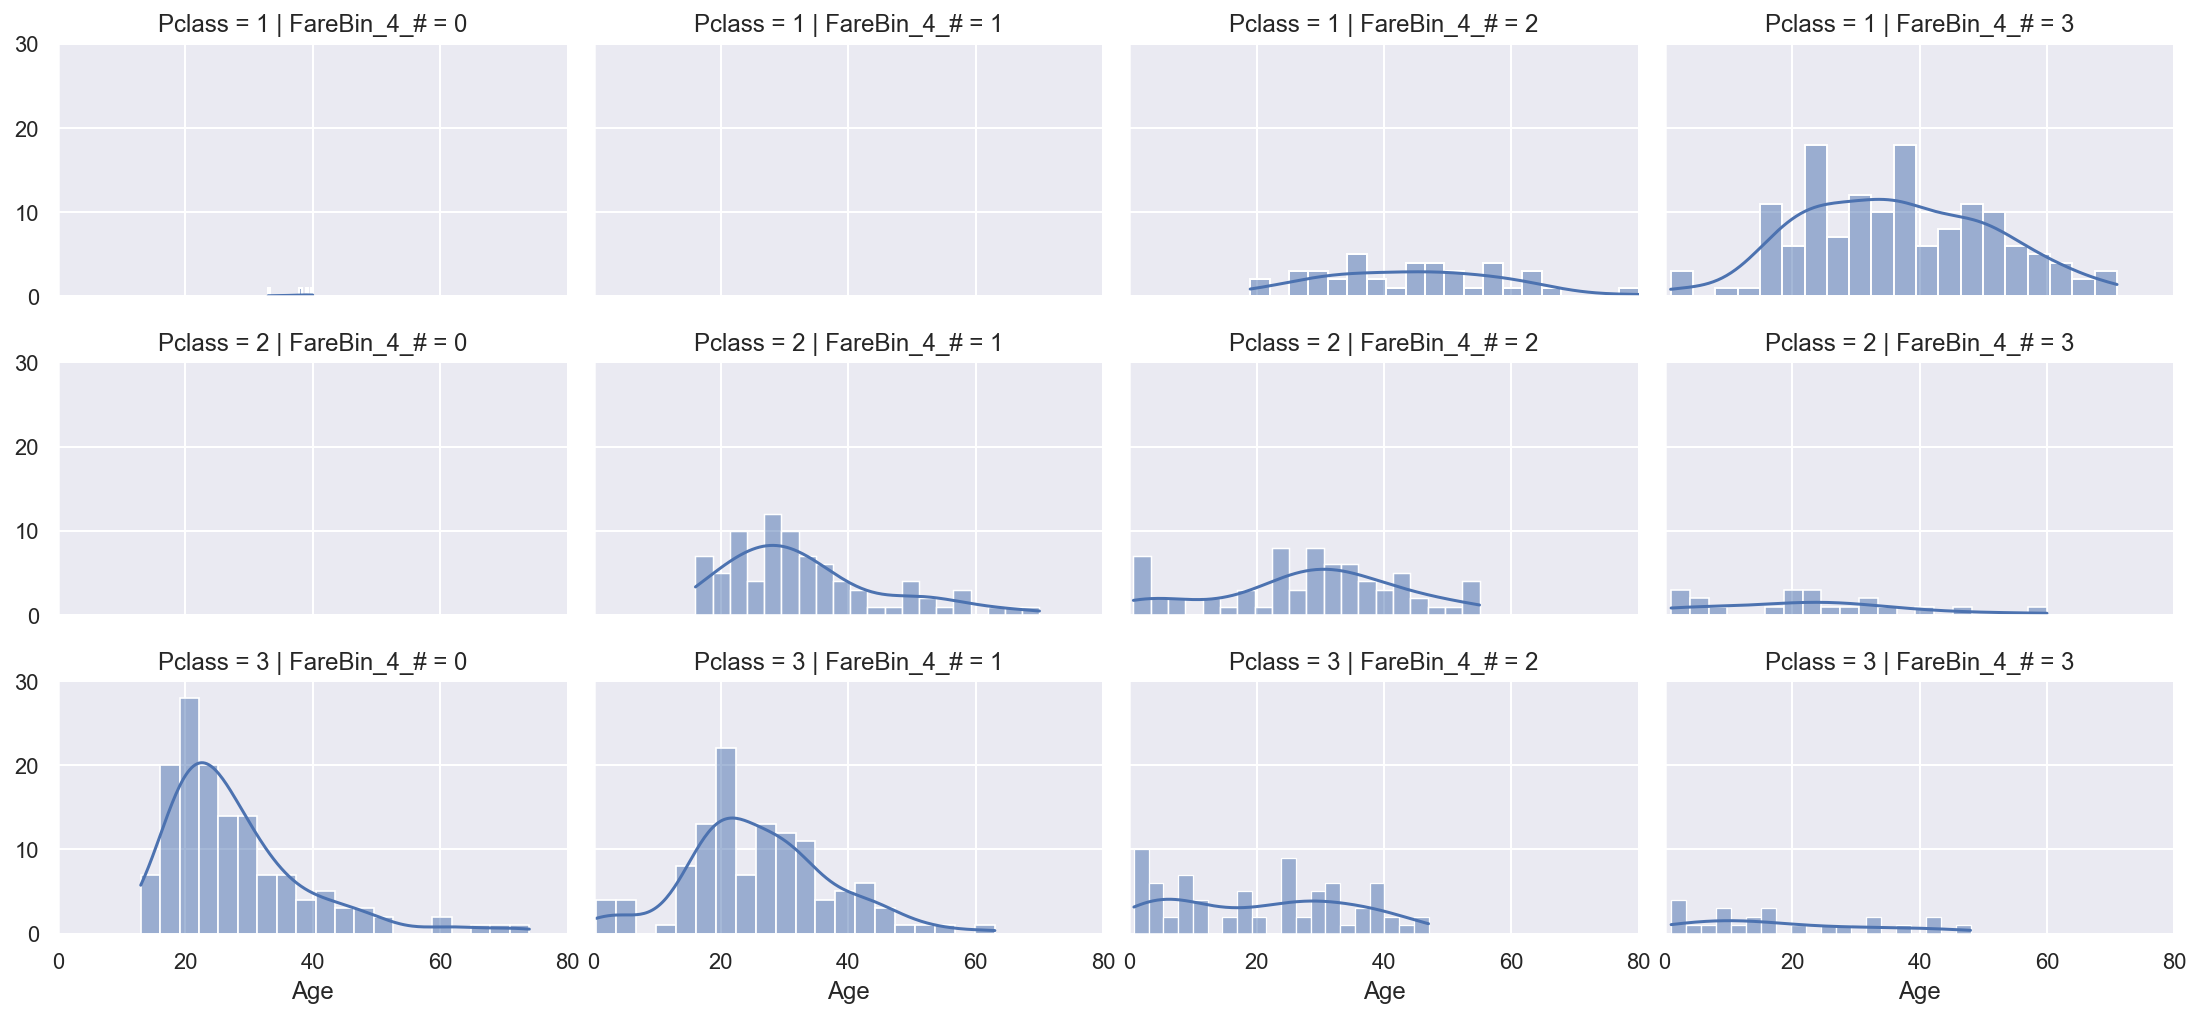

In [44]:
grid = sns.FacetGrid(df_train, row='Pclass', col='FareBin_4_#', height=2.4, aspect=1.6)
grid.map(sns.histplot, 'Age',kde=True, alpha=.5, bins=20)
grid.set(xlim=(0, 80), ylim=(0, 30))
plt.show()

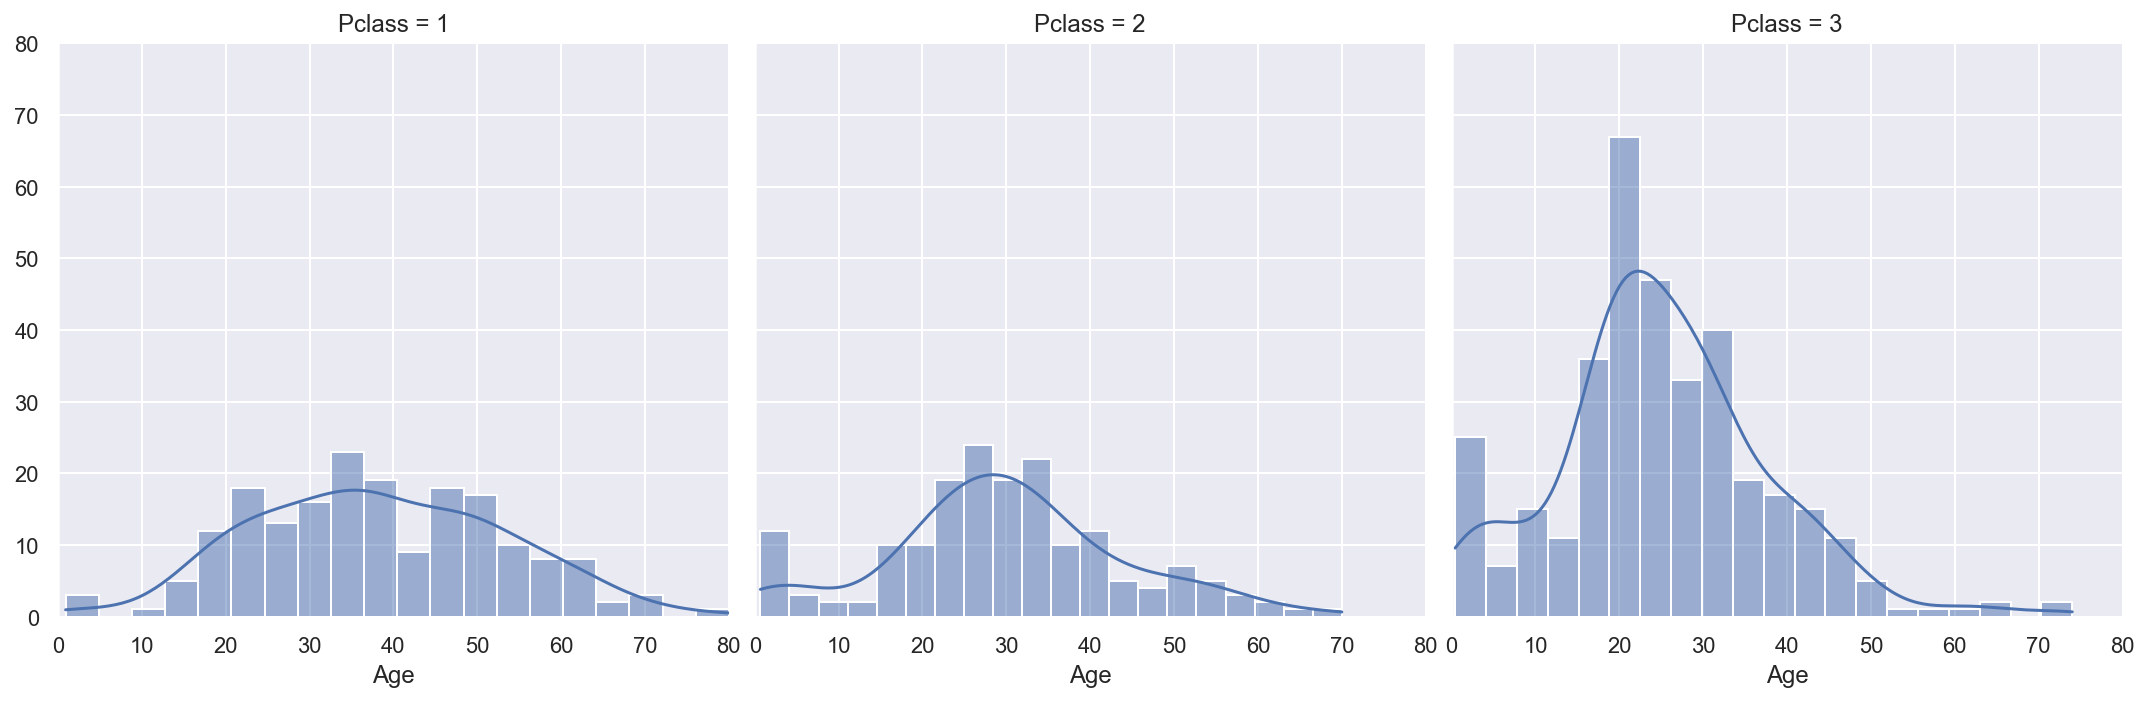

In [45]:
grid = sns.FacetGrid(df_train, col='Pclass', height=5, aspect=1)
grid.map(sns.histplot, 'Age',kde=True, alpha=.5, bins=20)
grid.set(xlim=(0, 80), ylim=(0, 80))
plt.show()

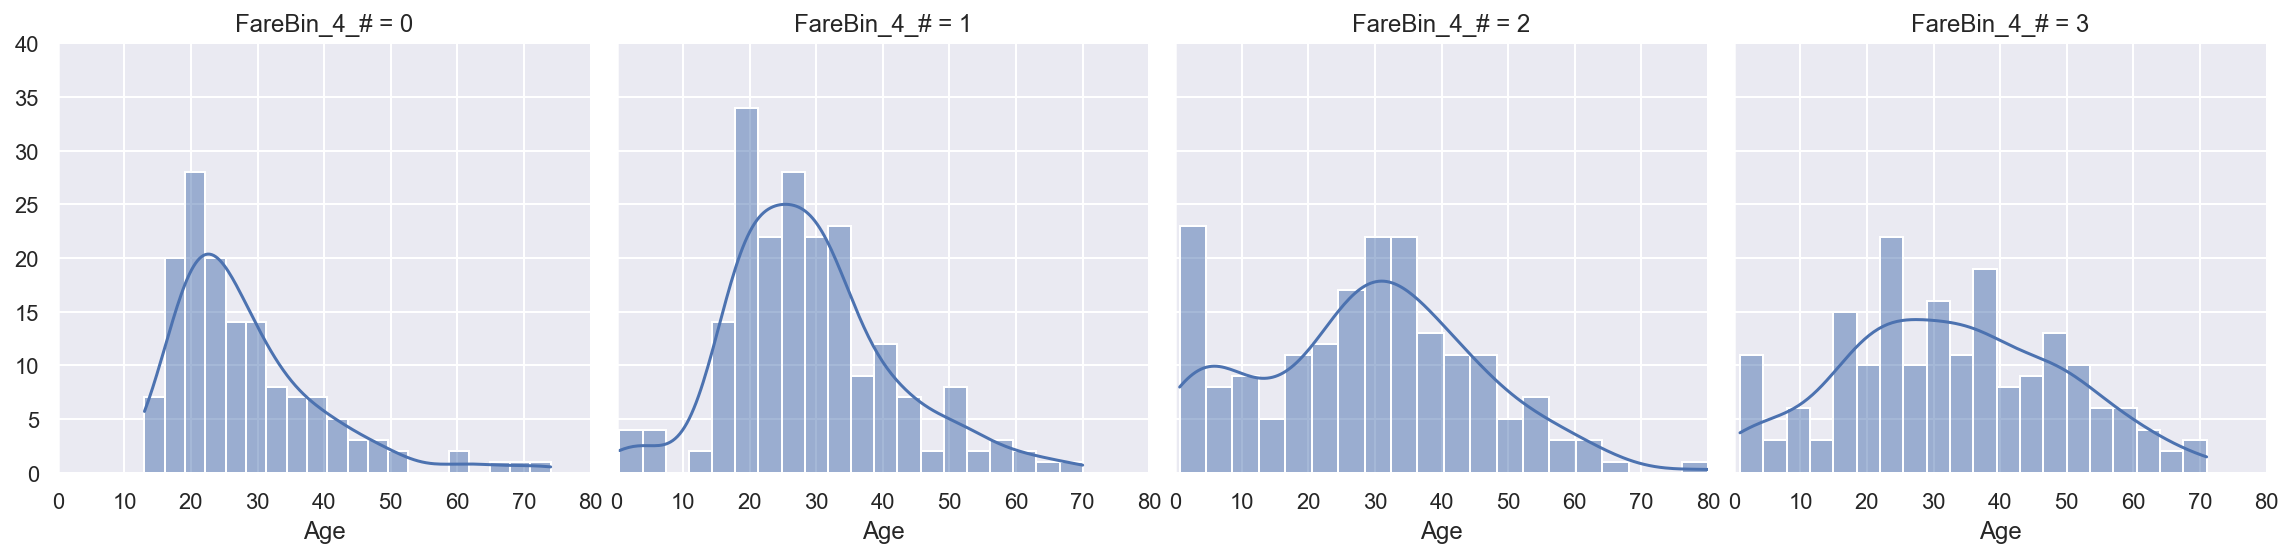

In [46]:
grid = sns.FacetGrid(df_train, col='FareBin_4_#', height=4, aspect=1)
grid.map(sns.histplot, 'Age',kde=True, alpha=.5, bins=20)
grid.set(xlim=(0, 80), ylim=(0, 40))
plt.show()

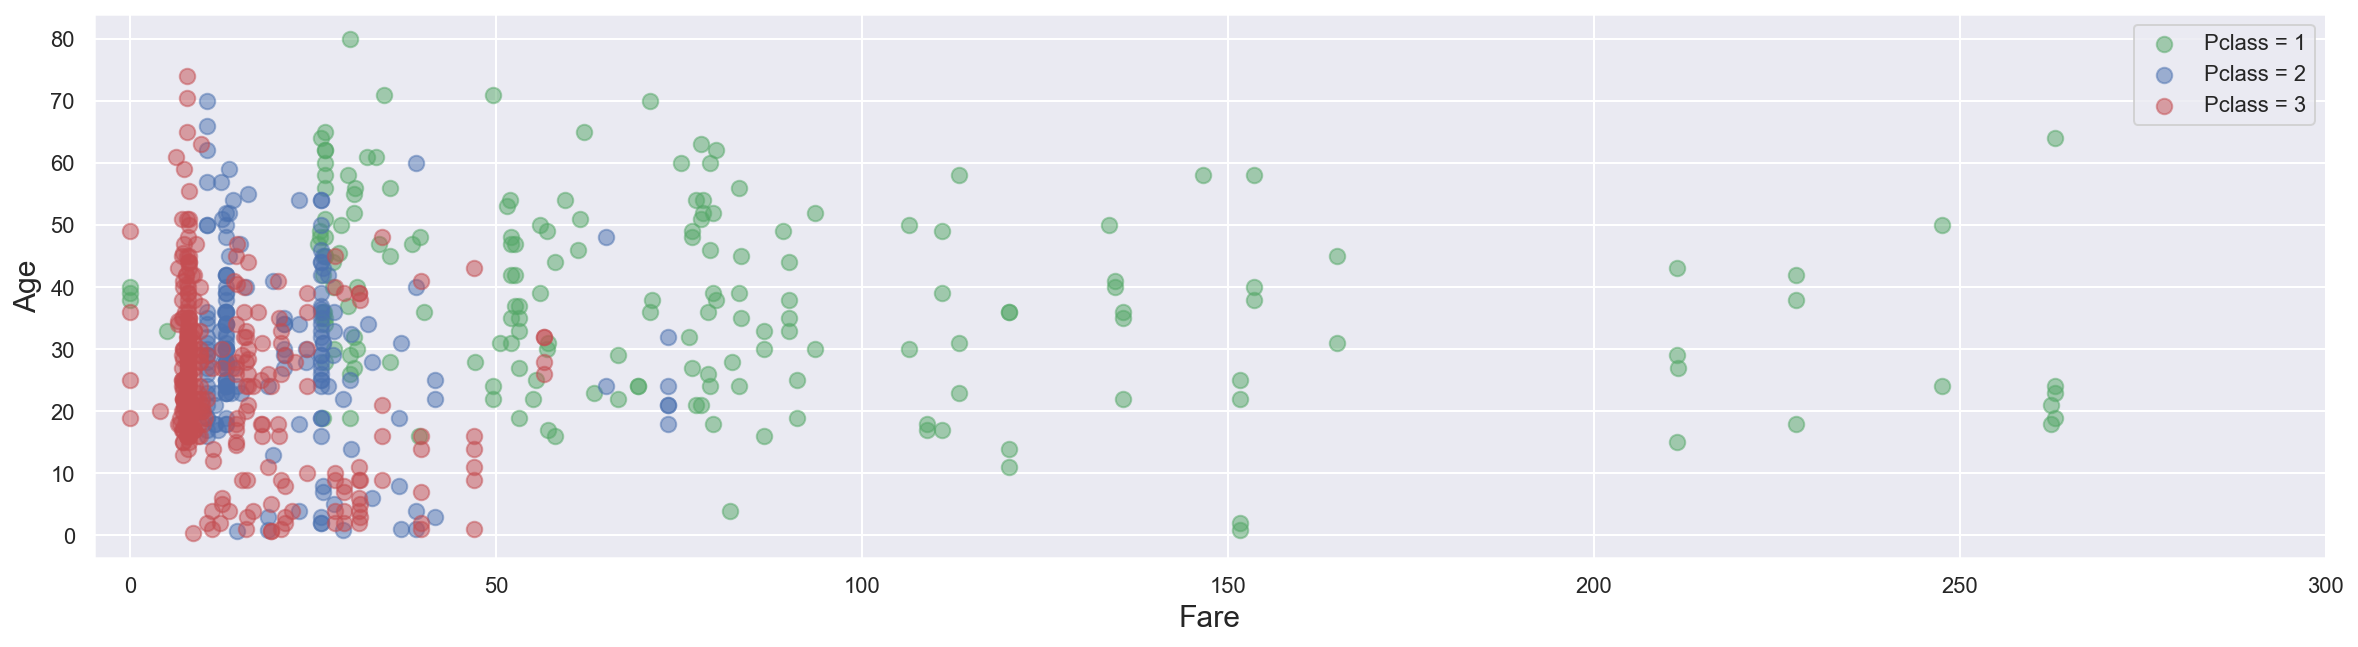

In [47]:
class_1 = df_train[df_train['Pclass']==1]
class_2 = df_train[df_train['Pclass']==2]
class_3 = df_train[df_train['Pclass']==3]

color = ['g', 'b', 'r']
alpha = 0.5
scale = 60.

plt.figure(figsize=(20, 5))
scatter = plt.scatter(class_1['Fare'], class_1['Age'], label='Pclass = 1', c=color[0], alpha=alpha, s=scale)
scatter = plt.scatter(class_2['Fare'], class_2['Age'], label='Pclass = 2', c=color[1], alpha=alpha, s=scale)
scatter = plt.scatter(class_3['Fare'], class_3['Age'], label='Pclass = 3', c=color[2], alpha=alpha, s=scale)
plt.xlabel('Fare', fontsize=15)
plt.ylabel('Age', fontsize=15)
plt.xlim(-5, 300)
plt.legend()
plt.show()

In [48]:
df_data['Age_pred1'] = df_data['Age']
guess_ages = np.zeros((2, 3))

for sex in range(0, 2):
    for pclass in range(0, 3):
        guess_df = df_data[(df_data['Sex#'] == sex) & (df_data['Pclass'] == pclass + 1)]['Age_pred1'].dropna()
        age_guess = guess_df.median()

        # Convert random age float to nearest .5 age
        guess_ages[sex, pclass] = int(age_guess/0.5 + 0.5) * 0.5
            
for sex in range(0, 2):
    for pclass in range(0, 3):
        df_data.loc[(df_data['Age_pred1'].isnull()) & (df_data['Sex#'] == sex) & (df_data.Pclass == pclass + 1), 'Age_pred1'] = guess_ages[sex,pclass]

df_data['Age_pred1'] = df_data['Age_pred1'].astype(int)

# Check our prediction correctly saved in df
df_data.loc[df_data.Age.isnull()].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex#,Fsize,IsAlone,FareBin,Fname,Connected_Survival,Embarked#,Title,Age_pred1
5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,0,1,1,1,Moran,0.5,3,0,25
17,18,1.0,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S,0,1,1,2,Williams,0.5,1,0,29
19,20,1.0,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C,1,1,1,0,Masselmani,0.5,2,4,22
26,27,0.0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C,0,1,1,0,Emir,0.5,2,0,25
28,29,1.0,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q,1,1,1,1,O'Dwyer,0.5,3,3,22


In [49]:
trans = df_data.groupby('Title')['Age'].median().values
df_data['Age_pred2'] = df_data['Age']
for i in range(5):
    df_data.loc[(df_data['Title'] == i) & (df_data['Age'].isnull()), 'Age_pred2'] = trans[i]

In [50]:
x_train = df_data[df_data.Age.notnull()]
y_train = df_data[df_data.Age.notnull()]['Age']
x_test = df_data[df_data.Age.isnull()]

select_feature = ['Sex#', 'Pclass', 'Title', 'Fare']

In [51]:
reg = LinearRegression()
reg.fit(x_train[select_feature], y_train)
reg.score(x_train[select_feature], y_train)

0.197924570571276

In [52]:
df_data['Age_pred3'] = df_data['Age']
df_data.loc[df_data['Age'].isnull(), 'Age_pred3'] = reg.predict(x_test[select_feature]).astype('int')

In [53]:
df_data.columns


Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Sex#', 'Fsize',
       'IsAlone', 'FareBin', 'Fname', 'Connected_Survival', 'Embarked#',
       'Title', 'Age_pred1', 'Age_pred2', 'Age_pred3'],
      dtype='object')

In [54]:
df_data['Age_pred4'] = df_data.Age


In [55]:
selected_features = ['PassengerId','Pclass', 'Sex#', 'SibSp', 'Parch', 'Fare', 'Age_pred4']

imputer = KNNImputer(n_neighbors=10, missing_values=np.nan)
imputer.fit(df_data[selected_features])

KNNImputer(n_neighbors=10)

In [56]:
df_data.loc[:, selected_features] = pd.DataFrame(imputer.transform(df_data[selected_features]), index=df_data.index, columns = selected_features)

In [57]:
df_data.loc[df_data.Age.isnull()].head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex#,Fsize,IsAlone,FareBin,Fname,Connected_Survival,Embarked#,Title,Age_pred1,Age_pred2,Age_pred3,Age_pred4
5,6.0,0.0,3.0,"Moran, Mr. James",male,NaN,0.0,0.0,330877,8.4583,NaN,Q,0.0,1,1,1,Moran,0.5,3,0,25,29.0,26.0,23.6
17,18.0,1.0,2.0,"Williams, Mr. Charles Eugene",male,NaN,0.0,0.0,244373,13.0000,NaN,S,0.0,1,1,2,Williams,0.5,1,0,29,29.0,33.0,21.0
19,20.0,1.0,3.0,"Masselmani, Mrs. Fatima",female,NaN,0.0,0.0,2649,7.2250,NaN,C,1.0,1,1,0,Masselmani,0.5,2,4,22,36.0,20.0,30.1
26,27.0,0.0,3.0,"Emir, Mr. Farred Chehab",male,NaN,0.0,0.0,2631,7.2250,NaN,C,0.0,1,1,0,Emir,0.5,2,0,25,29.0,26.0,31.0
28,29.0,1.0,3.0,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0.0,0.0,330959,7.8792,NaN,Q,1.0,1,1,1,O'Dwyer,0.5,3,3,22,22.0,23.0,26.1


In [58]:
selected_features = ['PassengerId','Pclass', 'Sex#', 'SibSp', 'Parch', 'Fare']

x_train = df_data[df_data.Age.notnull()][selected_features]
y_train = df_data[df_data.Age.notnull()]['Age']
x_test = df_data[df_data.Age.isnull()][selected_features]

In [59]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(len(selected_features),))) # The number of features we use
model.add(layers.Dropout(0.5))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1))

model.compile(loss='mse', optimizer='rmsprop', metrics=['acc', 'mae'])

history = model.fit(x_train[selected_features], y_train, batch_size=256, epochs=500, verbose=0)
model.evaluate(x_train[selected_features], y_train, batch_size=256, verbose=0)

[455.4779968261719, 0.021032504737377167, 17.443017959594727]

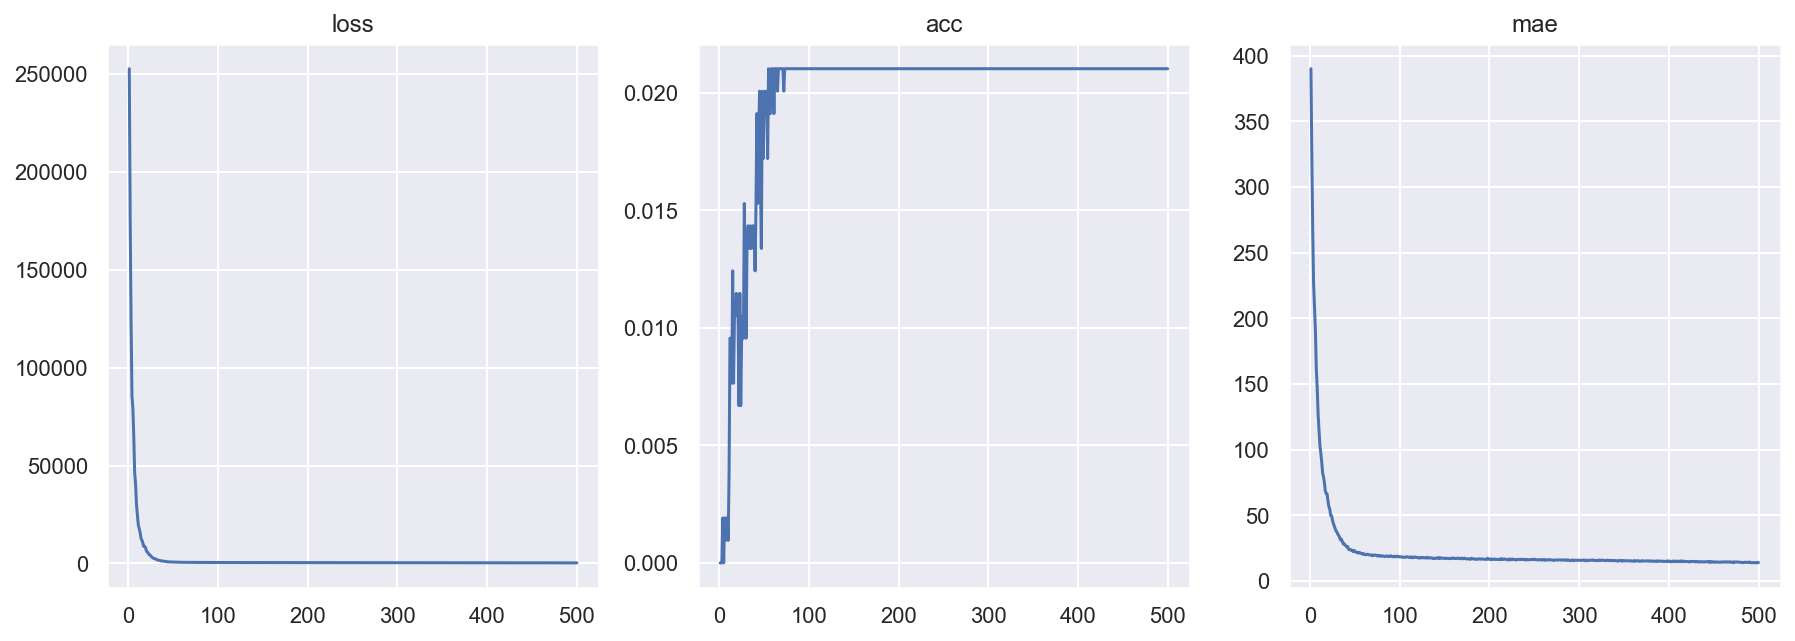

In [60]:
loss = history.history['loss']
acc = history.history['acc']
mae = history.history['mae']

epochs = range(1, len(loss) + 1)

fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(15, 5))
sns.lineplot(x=epochs, y=loss, palette='deep', ax=ax1)
sns.lineplot(x=epochs, y=acc, palette='deep', ax=ax2)
sns.lineplot(x=epochs, y=mae, palette='deep', ax=ax3)
ax1.title.set_text('loss')
ax2.title.set_text('acc')
ax3.title.set_text('mae')
plt.show()

In [61]:
df_data['Age_pred5'] = df_data['Age']
df_data.loc[df_data['Age'].isnull(), 'Age_pred5'] = model.predict(x_test[selected_features]).astype('int32')

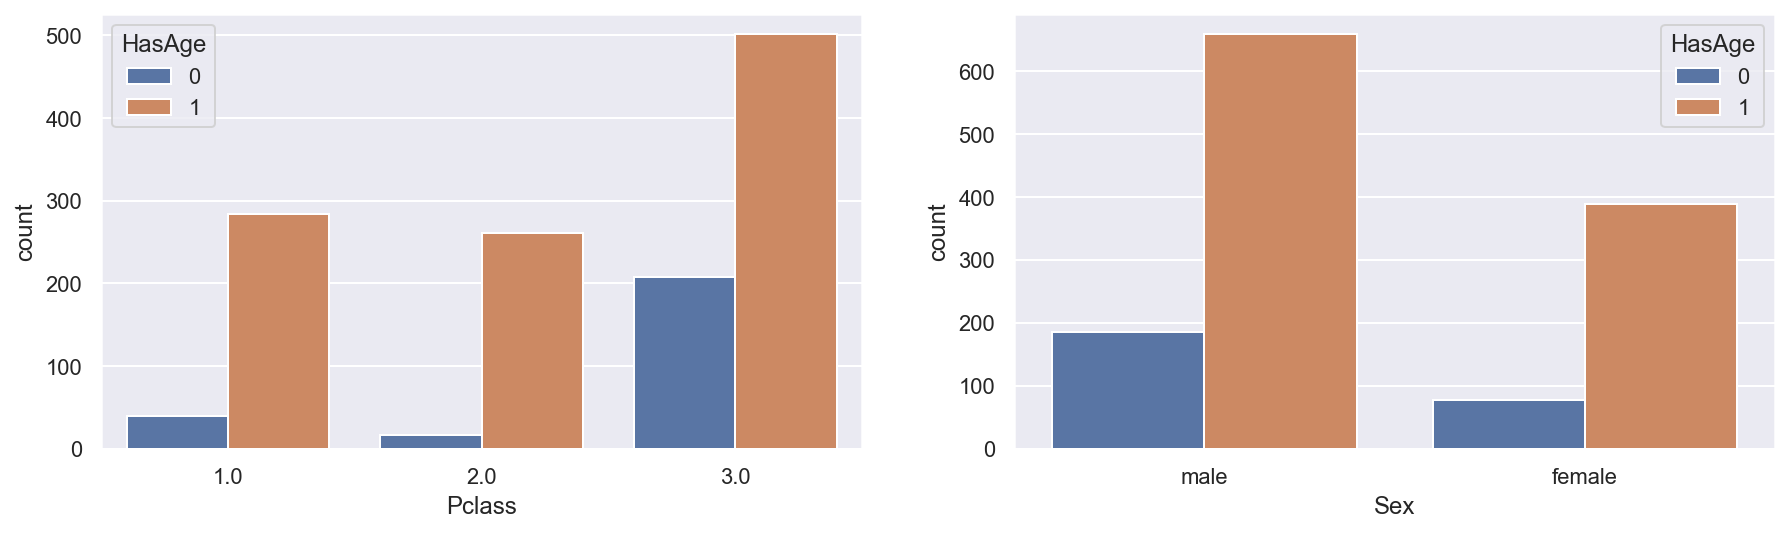

In [62]:
df_data['HasAge'] = df_data['Age'].notnull().map({True: 1, False: 0})
fig, [ax1, ax2] = plt.subplots(1, 2)

fig.set_figwidth(15)
sns.countplot(x=df_data['Pclass'], hue=df_data['HasAge'], ax=ax1)
sns.countplot(x=df_data['Sex'], hue=df_data['HasAge'], ax=ax2)
plt.show()

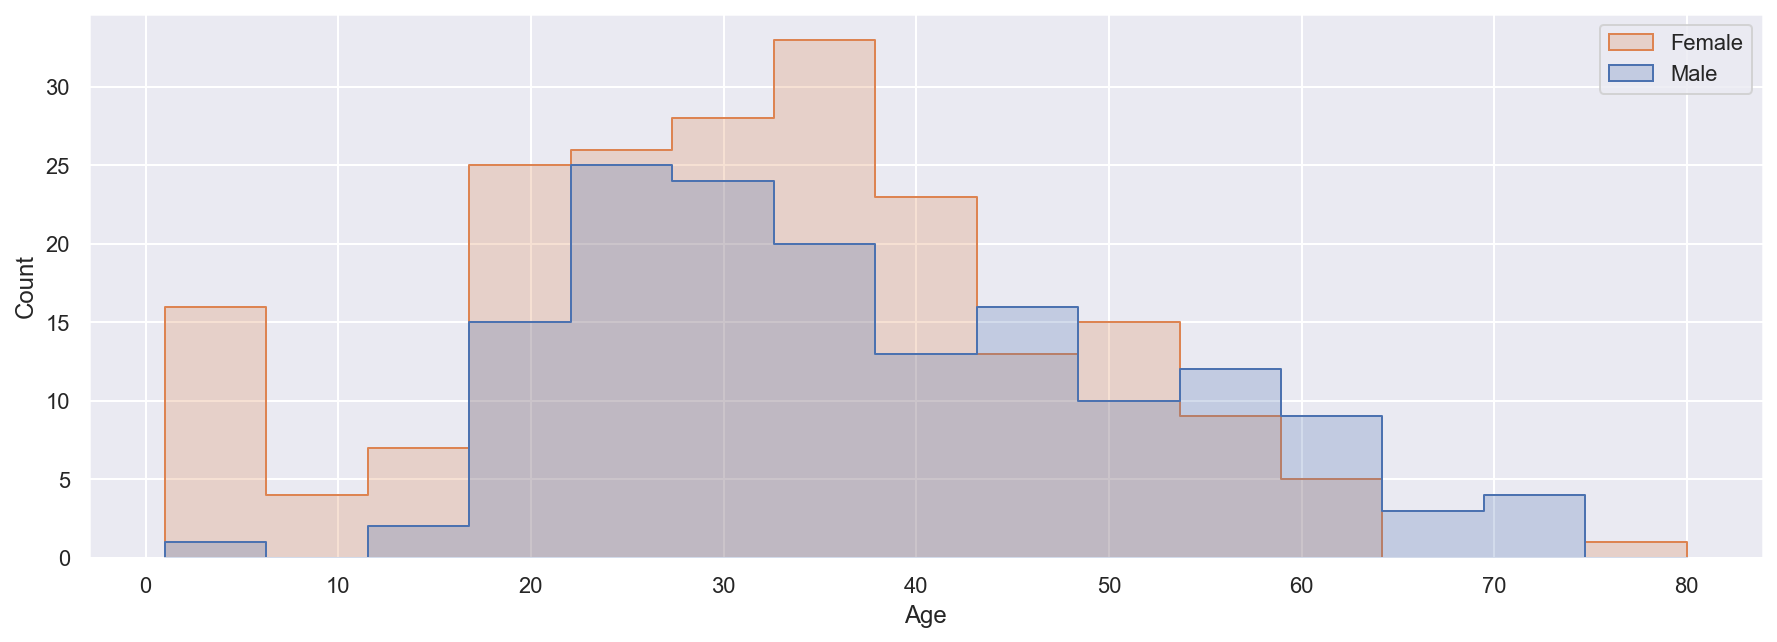

In [63]:
# Masks
Mask_Has_Age_P12 = df_data.loc[((df_data.HasAge == 1) & (df_data.Pclass != 3 ))]

fg, ax = plt.subplots(figsize=(15, 5))
ax = sns.histplot(Mask_Has_Age_P12, x='Age', hue='Survived', kde=False, bins=15, palette='deep', label='Survived', element='step')
ax.legend(['Female', 'Male'])
plt.show()

In [64]:
df_data['Minor_pred1'] = ((df_data['Age_pred1']) < 16)*1
df_data['Minor_pred2'] = ((df_data['Age_pred2']) < 16)*1
df_data['Minor_pred3'] = ((df_data['Age_pred3']) < 16)*1
df_data['Minor_pred4'] = ((df_data['Age_pred4']) < 16)*1
df_data['Minor_pred5'] = ((df_data['Age_pred5']) < 16)*1

In [65]:
df_data['AgeBin_pred1'] = pd.qcut(df_data['Age_pred1'], 5)
df_data['AgeBin_pred2'] = pd.qcut(df_data['Age_pred2'], 5)
df_data['AgeBin_pred3'] = pd.qcut(df_data['Age_pred3'], 5)
df_data['AgeBin_pred4'] = pd.qcut(df_data['Age_pred4'], 5)
df_data['AgeBin_pred5'] = pd.qcut(df_data['Age_pred5'], 5)

df_data['AgeBin_pred1'] = label_encoder.fit_transform(df_data['AgeBin_pred1'])
df_data['AgeBin_pred2'] = label_encoder.fit_transform(df_data['AgeBin_pred2'])
df_data['AgeBin_pred3'] = label_encoder.fit_transform(df_data['AgeBin_pred3'])
df_data['AgeBin_pred4'] = label_encoder.fit_transform(df_data['AgeBin_pred4'])
df_data['AgeBin_pred5'] = label_encoder.fit_transform(df_data['AgeBin_pred5'])

In [66]:
df_data[['PassengerId', 'Pclass', 'Sex#']] = df_data[['PassengerId', 'Pclass', 'Sex#']].astype('int32')
df_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex#,Fsize,IsAlone,FareBin,Fname,Connected_Survival,Embarked#,Title,Age_pred1,Age_pred2,Age_pred3,Age_pred4,Age_pred5,HasAge,Minor_pred1,Minor_pred2,Minor_pred3,Minor_pred4,Minor_pred5,AgeBin_pred1,AgeBin_pred2,AgeBin_pred3,AgeBin_pred4,AgeBin_pred5
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,A/5 21171,7.2500,NaN,S,0,2,0,0,Braund,0.5,1,0,22,22.0,22.0,22.0,22.0,1,0,0,0,0,0,1,1,1,1,2
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1.0,0.0,PC 17599,71.2833,C85,C,1,2,0,4,Cumings,0.5,2,4,38,38.0,38.0,38.0,38.0,1,0,0,0,0,0,3,3,3,3,3
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7.9250,NaN,S,1,1,1,1,Heikkinen,0.5,1,3,26,26.0,26.0,26.0,26.0,1,0,0,0,0,0,2,1,2,2,2
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,C123,S,1,2,0,4,Futrelle,0.0,1,4,35,35.0,35.0,35.0,35.0,1,0,0,0,0,0,3,3,3,3,3
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0.0,0.0,373450,8.0500,NaN,S,0,1,1,1,Allen,0.5,1,0,35,35.0,35.0,35.0,35.0,1,0,0,0,0,0,3,3,3,3,3


In [67]:
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]

In [68]:
train_features = ['Survived', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Sex#', 'Fsize', 'IsAlone', 'FareBin', 'Connected_Survival', 'Embarked#', 'Age_pred1', 'Age_pred2', 'Age_pred3', 'Age_pred4', 'HasAge', 'Age_pred5', 'Minor_pred1', 'Minor_pred2', 'Minor_pred3', 'Minor_pred4', 'Minor_pred5', 'AgeBin_pred1', 'AgeBin_pred2', 'AgeBin_pred3', 'AgeBin_pred4', 'AgeBin_pred5']

In [69]:
corr_mat = df_train[train_features].astype(float).corr()
corr_mat_fil = corr_mat.loc[:, 'Survived'].sort_values(ascending=False)
corr_mat_fil = pd.DataFrame(data=corr_mat_fil[1:])

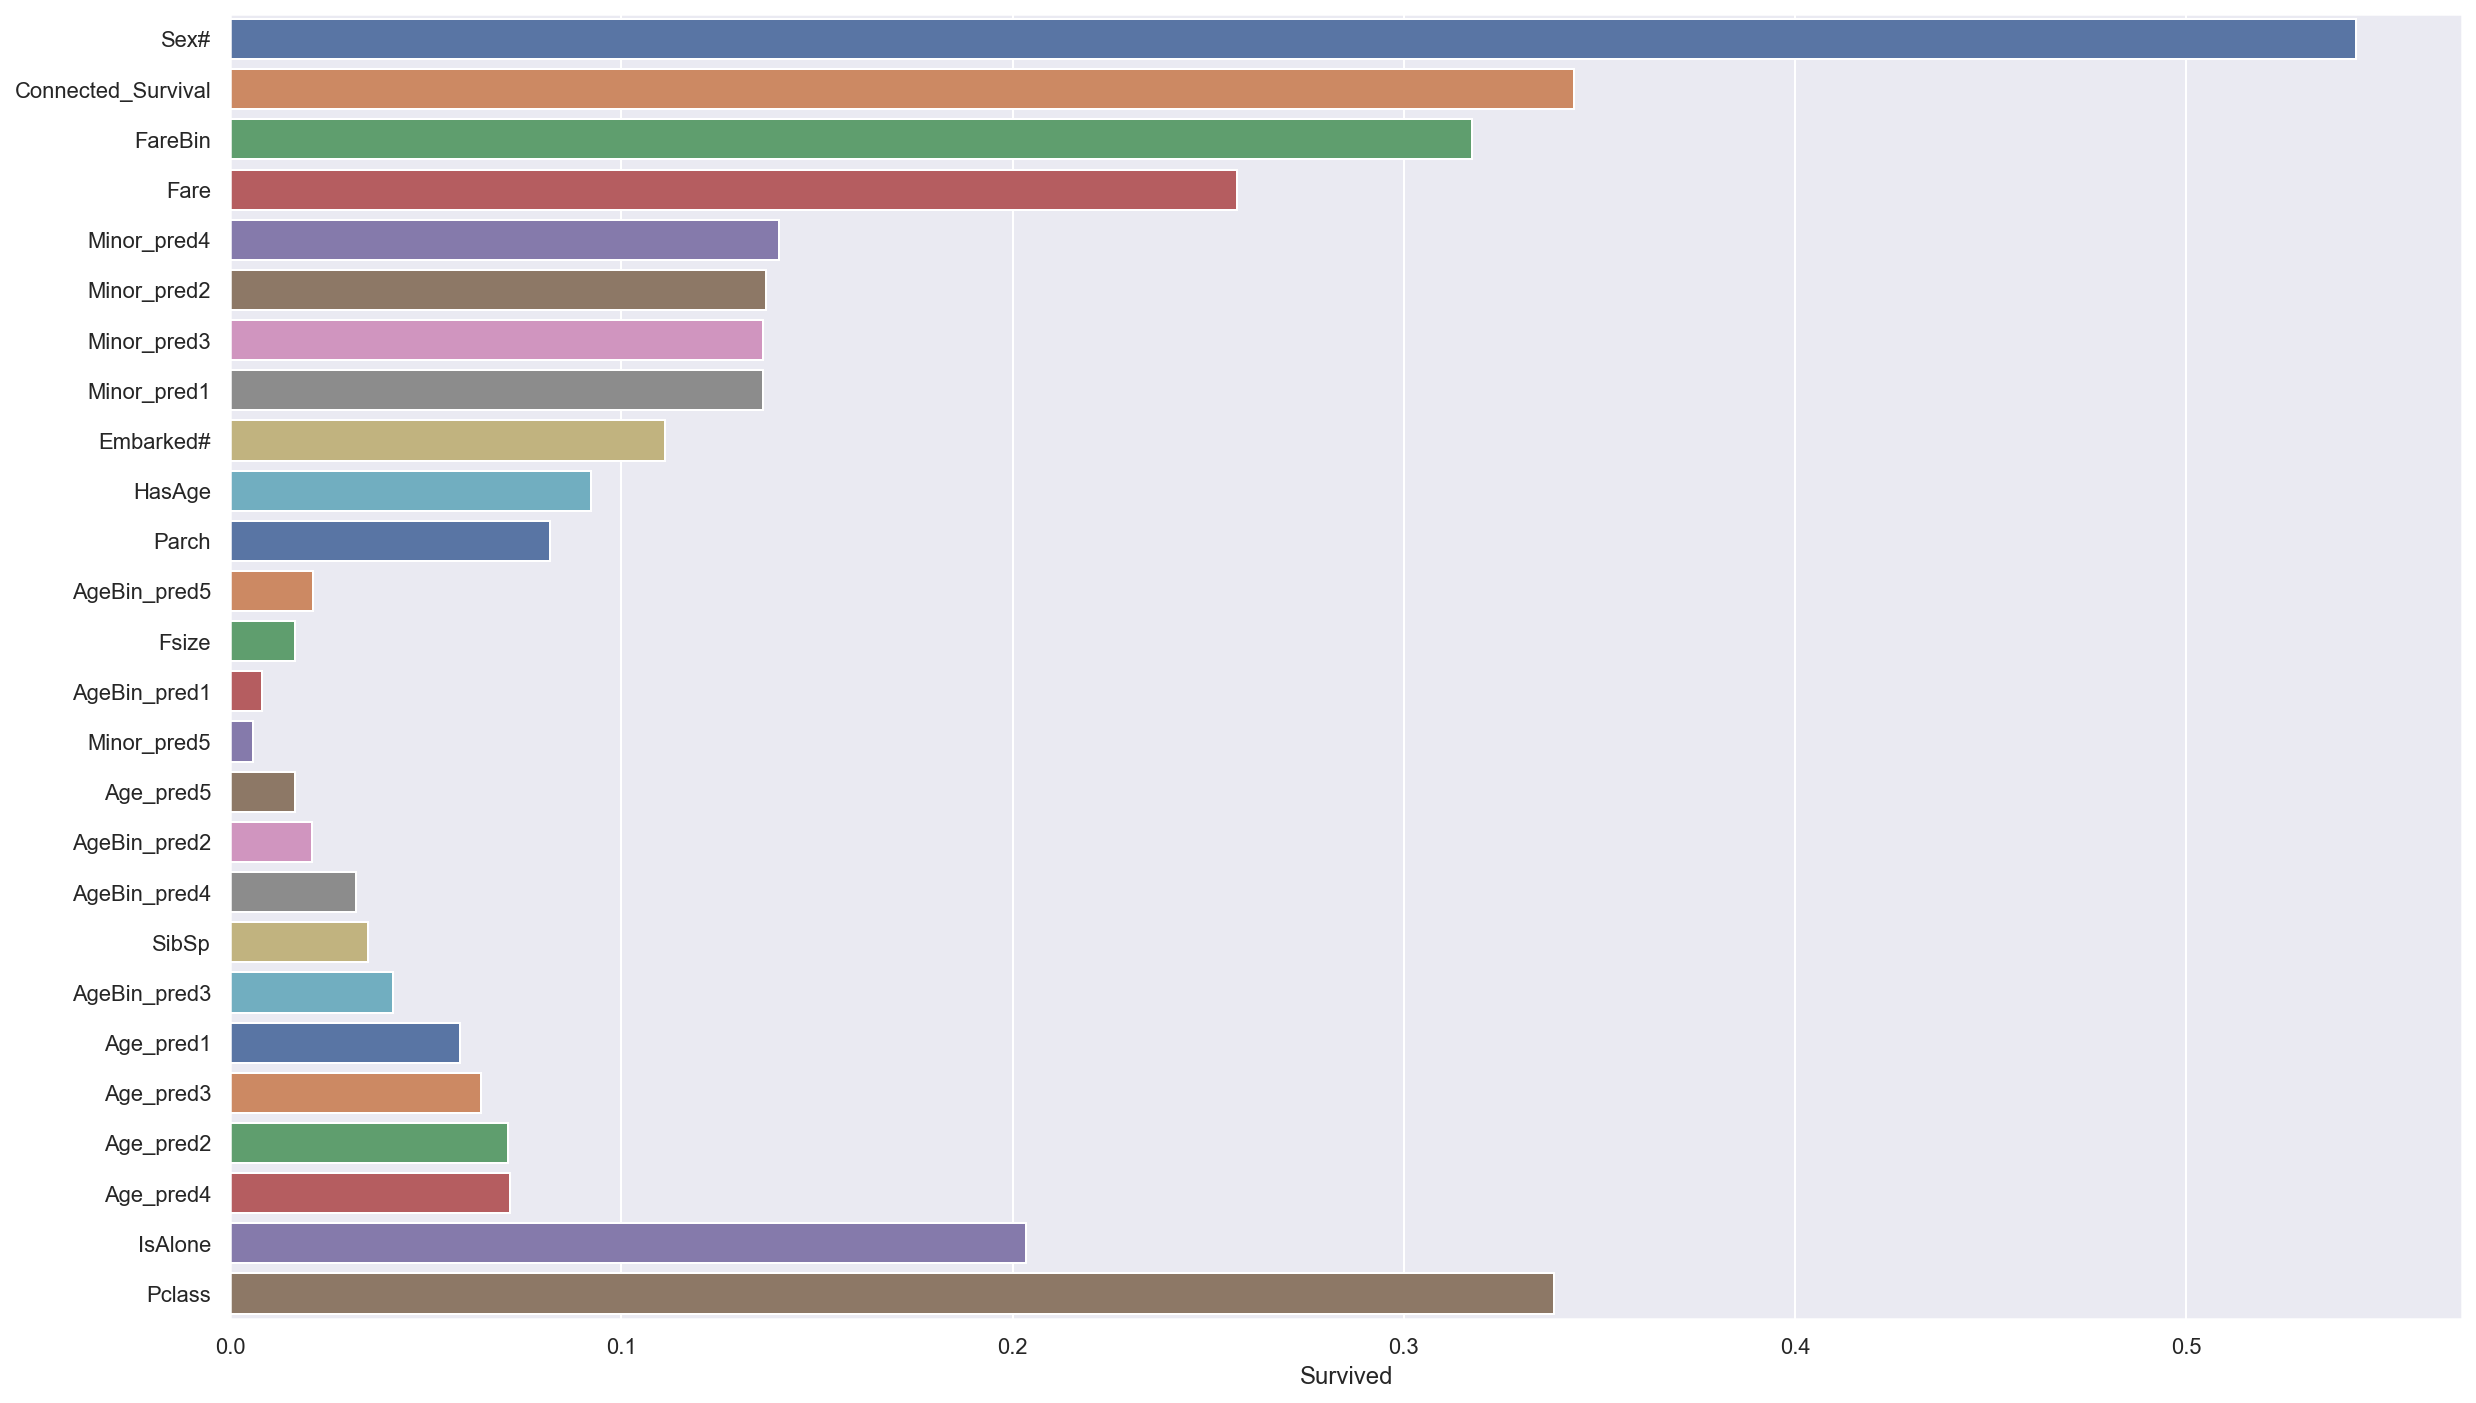

In [70]:
plt.figure(figsize=(20,12))
bar = sns.barplot(x=corr_mat_fil.Survived.abs(), y=corr_mat_fil.index, data=corr_mat_fil, palette='deep')

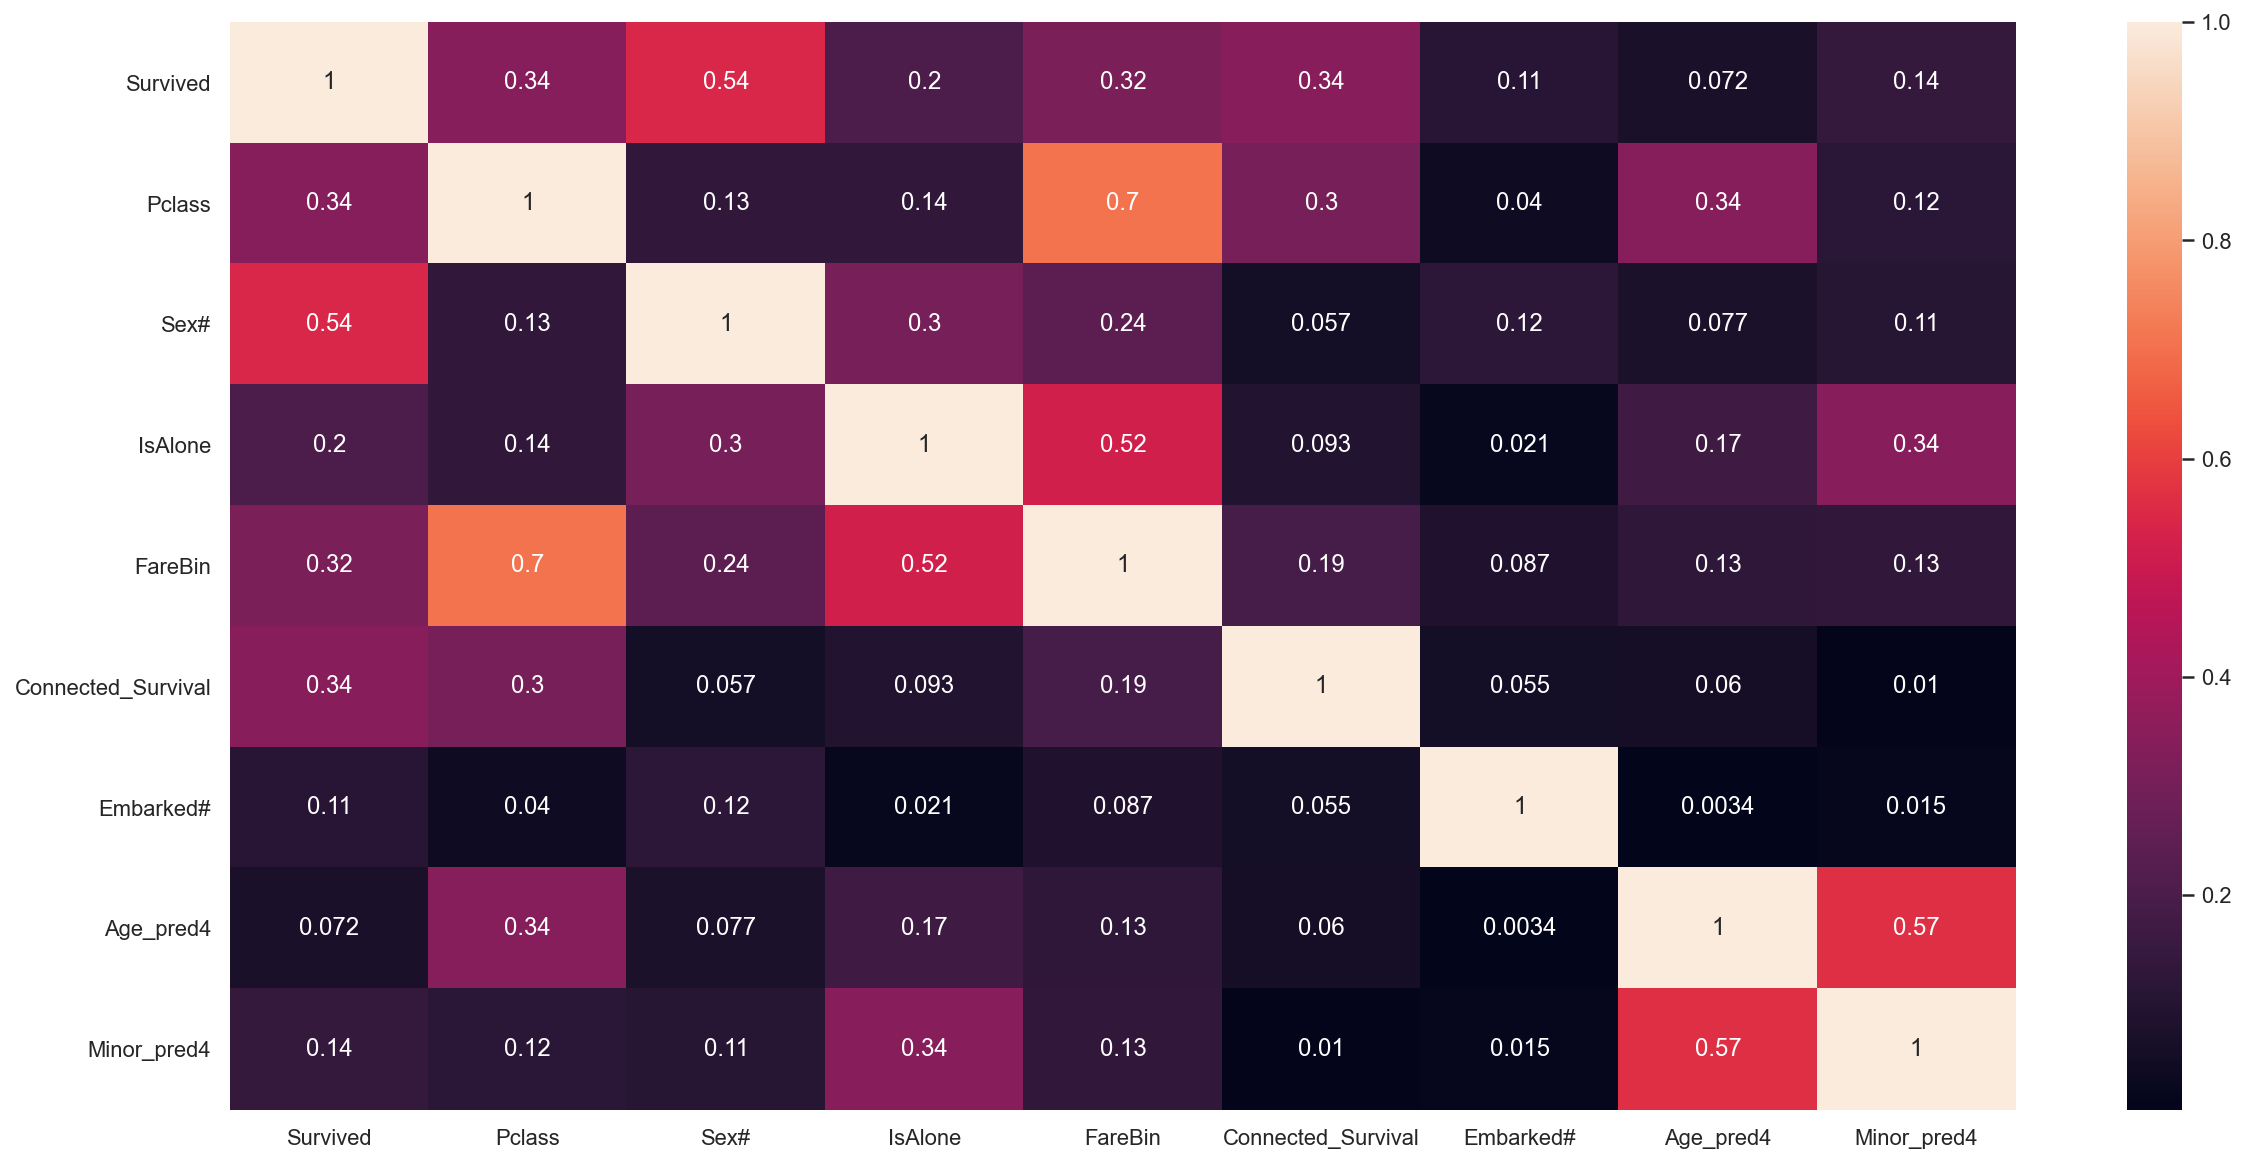

In [71]:
train_features = ['Survived', 'Pclass', 'Sex#', 'IsAlone', 'FareBin', 'Connected_Survival', 'Embarked#', 'Age_pred4', 'Minor_pred4']
corr_mat = df_train[train_features].astype(float).corr()

plt.figure(figsize=(20,10))
sns.heatmap(corr_mat.abs(), annot=True)
plt.show()

In [72]:
selected_features = ['Sex#', 'Pclass', 'FareBin', 'Connected_Survival', 'Minor_pred2']

#=====================================================================================================
# 0.79665: Sex#, Pclass, FareBin(#6), Connected_Survival, Minor_pred2, n=250, min=20
# 0.81100: Sex#, Pclass, FareBin(#5), Connected_Survival, Minor_pred2, n=250, min=20      Current Best
# 0.81100: Sex#, Pclass, FareBin(#5), Connected_Survival, Minor_pred2, n=300, min=20
# 0.80861: Sex#, Pclass, FareBin(#5), Connected_Survival, Minor_pred4, n=300, min=20
#=====================================================================================================

df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]

x_train = df_train[selected_features]
y_train = df_train['Survived']
x_test = df_test[selected_features]

In [73]:
model = RandomForestClassifier(random_state=2)

grid_parameters = {'n_estimators': [i for i in range(300, 601, 50)], 'min_samples_split' : [10, 20, 30, 40]}
grid = GridSearchCV(estimator=model, param_grid=grid_parameters)
grid_result = grid.fit(x_train, y_train)

# summarize results
print('Best: {} using {}'.format(grid_result.best_score_, grid_result.best_params_))

Best: 0.8439645973259683 using {'min_samples_split': 40, 'n_estimators': 300}


In [74]:
n_estimator = grid_result.best_params_['n_estimators']
min_samples_split = grid_result.best_params_['min_samples_split']

RFC = RandomForestClassifier(random_state=2, n_estimators=250, min_samples_split=20)
RFC.fit(x_train, y_train)
y_pred = RFC.predict(x_test)

output = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': y_pred})
output = output.astype('int')
output.to_csv('RFC_prediction.csv', index=False)
print('Your file was successfully saved!')

Your file was successfully saved!


In [75]:
# split into training and testing data
selected_features = ['Sex#', 'Pclass', 'FareBin', 'Connected_Survival', 'Minor_pred4', 'Embarked#', 'IsAlone', 'Title']
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]
x_train = df_train[selected_features]
y_train = df_train['Survived']
x_test = df_test[selected_features]

In [79]:
# Function to create model, required for KerasClassifier
# include adjustable parameters optimizer and init
def create_keras_model(optimizer='adam', init='glorot_normal'):
    
    # create model
    model = models.Sequential()
    model.add(layers.Dense(8, activation='relu', kernel_initializer=init, kernel_regularizer=l2(0.1), input_shape=(x_train.shape[1],)))
    model.add(layers.Dense(16, activation='relu', kernel_initializer=init, kernel_regularizer=l2(0.1)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(16, activation='relu', kernel_initializer=init, kernel_regularizer=l2(0.1)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [80]:
optimizer = grid_result.best_params_['optimizer']
epochs = grid_result.best_params_['nb_epoch']
batch_size = grid_result.best_params_['batch_size']
init = grid_result.best_params_['init']

keras_model = create_keras_model(optimizer=optimizer, init=init)
keras_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

y_pred = keras_model.predict(x_test)

output = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': y_pred.reshape(y_pred.shape[0],)})
output = output.astype('int')
output.to_csv('keras_prediction.csv', index=False)
print('Your file was successfully saved!')

Your file was successfully saved!
